# Аналитика HH.ru

**Описание:**

Исследование базы вакансий  на hh.ru для Аналитиков данных и специалистов по Data Science.

**Цель проекта:** 

Выявить различия в предлагаемых вакансиях для Аналитиков данных и специалистов по Data Science.

**Исходные данные:**
    
- Данные получены из API сайта HH.ru. Данные прошли предварительную обработку и очистку.
- Ссылка на данные: https://disk.yandex.ru/d/wgSfAyM5dnzOpw


**Ход исследования**

Получим данные из 2х файлов **vacancies_da.xlsx** и **vacancies_ds.xlsx**
Далее иследование будет включать следующие шаги:

1. Предобработка данных.
2. Исследовательский анализ данных.
3. Выявление грейда требуемых специалистов по названию вакансии или по колонке с требуемым опытом.
4. Определение доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и специалистов по Data Science.
5. Определение типичного места работы для Аналитика данных и специалиста по Data Science по следующим параметрам: ТОП-работодателей по числу вакансий, зарплата, тип занятости, график работы. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
6. Определение, какие навыки спрашивают чаще - твердые или мягкие. К какому грейду и к какой специальности требований больше.
7. Определение наиболее желаемых кандидатов на вакансии Аналитик данных и Data Science по следующим параметрам: самые важные hard-skils, самые важные soft-skils. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
8. Расчет помесячной динамики количества вакансий для Аналитика данных и Data Science. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
9. Формулирование выводов и рекомендаций.


**Описание данных**

Данные представленны в 2х таблицах: **vacancies_da.xlsx** и **vacancies_ds.xlsx** с информацией о вакансиях для Аналитиков данных и Специалистов по Data Science соответственно, каждая из которых содерждит следующие поля: 

* `id` - Уникальный идентификатор вакансии.
* `name` - Название вакансии.
* `published_at` - Дата публикации.
* `alternate_url` - Ссылка на вакансию.
* `type` - Статус вакансии на момент получения данных от api и передачи их в базу.
* `employer` - Работодатель.
* `department` - Работодатель, отдел.
* `area` - Регион места работы.
* `experience` - Требуемый опыт работы.
* `key_skills` - Ключевые навыки, в том числе найденные при анализе полного текста вакансии. Поле генерируется после получения информации от api.
* `schedule` - График работы.
* `employment` - Тип занятости.
* `description` - Описание вакансии.
* `description_lemmatized` - Лемматизированное описание вакансии.
* `salary_from` - Нижняя граница предлагаемой заработной платы.
* `salary_to` - Верхняя граница предлагаемой заработной платы.
* `salary_bin` - Категория зарплаты.
* `key_skills_from_key_skills_field` - Ключевые навыки из поля вакансии key_skills.
* `hard_skills_from_description` - “Твердые” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от api. 
* `soft_skills_from_description` - “Мягкие” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от api.

## Загрузка и предобработка данных

In [1]:
import pandas as pd        # импортируем библиотеку pandas
import matplotlib.pyplot as plt # импортируем библиотеку для построения графиков
import plotly # импорт библиотеки для построение интерактивных графиков
import plotly.graph_objs as go
import plotly.express as px 
from plotly.subplots import make_subplots
#import numpy as np # импортируем библиотеку numpy
from datetime import datetime, timedelta # импортируем библиотеку для работы с типами datetime
import os

import warnings
import re
import matplotlib.patches as mpatches
import seaborn as sns
import sys
import requests
from collections import Counter


warnings.filterwarnings("ignore", "use_inf_as_na")
sns.set_theme(style="whitegrid", palette="pastel")

Ознакомление с данными

In [2]:
# Чтение файлов Excel и перевод столбца "дата публикации вакансии" в формат даты
da = pd.read_excel('vacancies_da.xlsx', parse_dates=['published_at'])
ds = pd.read_excel('vacancies_ds.xlsx', parse_dates=['published_at'])

In [3]:
#посмотрим на таблицу с вакансиями аналитиков
display(da.head(2))
display(da.tail(2))


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100039284,Junior аналитик данных (исследователь),2024-05-24 09:37:04,https://hh.ru/vacancy/100039284,Открытая,DNS Головной офис,NaN,Владивосток,Junior (no experince),"['Power BI', 'СУБД', 'Python', 'SQL']",Полный день,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,60000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД",NaN,NaN
1,100039480,Аналитик данных,2024-05-24 09:39:00,https://hh.ru/vacancy/100039480,Открытая,Комус,NaN,Москва,Junior (no experince),"['MS SQL', 'Работа с базами данных', 'MS Excel']",Полный день,Полная занятость,сегодня комус один из крупнейших поставщиков о...,сегодня комус крупный поставщик офисный товар ...,NaN,NaN,ЗП не указана,"Работа с базами данных, MS SQL, MS Excel",NaN,NaN


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
1799,99989203,Аналитик данных на производстве \ Data Analyst...,2024-05-23 19:40:04,https://hh.ru/vacancy/99989203,Открытая,Марс,NaN,Одинцово,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'MS Power BI', 'Pytho...",Полный день,Полная занятость,"аналитик будет заниматься сбором, обработкой, ...",аналитик заниматься сбор обработка изучение ан...,NaN,NaN,ЗП не указана,"MS Power BI, Аналитика, Python, SQL, Tableau, ...",NaN,NaN
1800,99989339,Аналитик данных на производстве \ Data Analyst...,2024-05-23 19:41:22,https://hh.ru/vacancy/99989339,Открытая,Марс,NaN,Ульяновск,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'MS Power BI', 'Pytho...",Полный день,Полная занятость,"аналитик будет заниматься сбором, обработкой, ...",аналитик заниматься сбор обработка изучение ан...,NaN,NaN,ЗП не указана,"MS Power BI, Аналитика, Python, SQL, Tableau, ...",NaN,NaN


In [4]:
#посмотрим на таблицу с вакансиями датасаентистов
display(ds.head(2))
display(ds.tail(2))

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,100049339,Стажер Data Science (Новосибирск),2024-05-24 10:44:01,https://hh.ru/vacancy/100049339,Открытая,СБЕР,Сбер для экспертов,Новосибирск,Junior (no experince),[],Полный день,Стажировка,sberseasons - оплачиваемая программа стажирово...,sberseasons оплачивать программа стажировка ра...,NaN,NaN,ЗП не указана,NaN,NaN,NaN
1,100051447,Data Scientist,2024-05-24 10:58:18,https://hh.ru/vacancy/100051447,Открытая,Бюро кредитных историй Скоринг Бюро,NaN,Москва,Junior+ (1-3 years),"['Python', 'Hadoop', 'Machine Learning', 'Рабо...",Удаленная работа,Полная занятость,бюро кредитных историй «скоринг бюро» является...,бюро кредитный история скоринг бюро являться к...,NaN,NaN,ЗП не указана,"SQL, MS SQL, Big Data, Python, Spark, Hadoop, ...",Pandas,"Документация, Аналитическое мышление"


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
972,99964605,Разработчик в области машинного обучения и бол...,2024-06-10 15:09:31,https://hh.ru/vacancy/99964605,Открытая,Ульянова Надежда Михайловна,NaN,Москва,Junior+ (1-3 years),"['Python', 'PyTorch', 'Keras', 'Решение нестан...",Удаленная работа,Частичная занятость,компания по разработке мобильных игр p.d. play...,компания разработка мобильный игра p d playgen...,NaN,NaN,ЗП не указана,"Tensorflow, Аналитическое мышление, Анализ дан...",NaN,NaN
973,99973974,Middle/Senior Data Scientist (блок Управление ...,2024-05-23 16:29:00,https://hh.ru/vacancy/99973974,Открытая,СБЕР,Сбер для экспертов,Москва,Middle (3-6 years),"['Pandas', 'Документация', 'Аналитическое мышл...",Полный день,Полная занятость,в нашей команде вы получите возможность работа...,наш команда получать возможность работать созд...,NaN,NaN,ЗП не указана,NaN,Pandas,"Документация, Аналитическое мышление"


Обединим датасеты, чтобы было удобнее с ними работать.

In [5]:
# Объединение данных
df = pd.concat([da, ds], ignore_index=True)
df = pd.concat([da.assign(source='da'), ds.assign(source='ds')], ignore_index=True)
# Запомним изначальный размер датасета, чтобы после предобработки понимать какой процент данных мы потеряли
start_df_size = df.shape[0]
# Просмотр первых строк объединенных данных
display(df.head())


,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
0,100039284,Junior аналитик данных (исследователь),2024-05-24 09:37:04,https://hh.ru/vacancy/100039284,Открытая,DNS Головной офис,NaN,Владивосток,Junior (no experince),"['Power BI', 'СУБД', 'Python', 'SQL']",...,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,60000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД",NaN,NaN,da
1,100039480,Аналитик данных,2024-05-24 09:39:00,https://hh.ru/vacancy/100039480,Открытая,Комус,NaN,Москва,Junior (no experince),"['MS SQL', 'Работа с базами данных', 'MS Excel']",...,Полная занятость,сегодня комус один из крупнейших поставщиков о...,сегодня комус крупный поставщик офисный товар ...,NaN,NaN,ЗП не указана,"Работа с базами данных, MS SQL, MS Excel",NaN,NaN,da
2,100042705,Аналитик данных (исследователь),2024-05-24 10:01:25,https://hh.ru/vacancy/100042705,Открытая,DNS Головной офис,NaN,Владивосток,Junior+ (1-3 years),"['SQL', 'Power BI', 'СУБД', 'Python', 'Clickho...",...,Полная занятость,наше направление занимается повышением эффекти...,наш направление заниматься повышение эффективн...,90000.0,NaN,ЗП не указана,"SQL, Power BI, Python, СУБД, BPMN, Clickhouse",NaN,NaN,da
3,100046788,Ведущий аналитик данных,2024-05-24 10:28:18,https://hh.ru/vacancy/100046788,Открытая,Х5 Group,"X5 GROUP, Центральный офис",Москва,Junior+ (1-3 years),"['Анализ данных', 'Коммуникация', 'SQL', 'MS O...",...,Полная занятость,задачи: разработка бизнес-моделей для группов...,задача разработка бизнес модель групповой прог...,NaN,NaN,ЗП не указана,"MS Office, SQL, Python, Hadoop, Нive, Аналитич...","Pandas, Юнит-экономика",Коммуникация,da
4,100056244,Аналитик данных,2024-05-24 11:27:40,https://hh.ru/vacancy/100056244,Открытая,ЛУКОЙЛ,NaN,Москва,Middle (3-6 years),['Документация'],...,Полная занятость,"обязанности: участие в проектировании, разраб...",обязанность участие проектирование разработка ...,NaN,NaN,ЗП не указана,NaN,NaN,Документация,da


In [6]:
# посмотрим основную информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                2775 non-null   int64         
 1   name                              2775 non-null   object        
 2   published_at                      2775 non-null   datetime64[ns]
 3   alternate_url                     2775 non-null   object        
 4   type                              2775 non-null   object        
 5   employer                          2775 non-null   object        
 6   department                        934 non-null    object        
 7   area                              2775 non-null   object        
 8   experience                        2775 non-null   object        
 9   key_skills                        2775 non-null   object        
 10  schedule                          2775 non-null 

В объединенном датасете всего 2775 записей. Видно, что департамент и заработная плата не всегда указывается в вакансиях.

Посмотрим есть ли повторяющиеся вакансии, которые вошли в обе таблицы.

In [7]:
grid = (df.name.str.lower().str.contains(r'data scien')
    & (df.name.str.lower().str.contains(r'analyst')
    | df.name.str.lower().str.contains(r'аналитик данных')))
df[grid].sort_values(by='id')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
412,92068025,"Аналитик данных (data scientist, data engineer)",2024-03-12 12:42:01,https://hh.ru/vacancy/92068025,Открытая,Федеральное государственное автономное учрежде...,NaN,Москва,Middle (3-6 years),"['Пусконаладочные работы', 'Оформление описани...",...,Полная занятость,в настоящее время фгау «нии «цэпп» расширяет к...,настоящий время фгау нии цэпп расширять команд...,100000.0,NaN,ЗП не указана,"Python, Системы автоматического контроля, Созд...",NaN,Документация,da
2025,92068025,"Аналитик данных (data scientist, data engineer)",2024-03-12 12:42:01,https://hh.ru/vacancy/92068025,Открытая,Федеральное государственное автономное учрежде...,NaN,Москва,Middle (3-6 years),"['Python', 'Пусконаладочные работы', 'Создание...",...,Полная занятость,в настоящее время фгау «нии «цэпп» расширяет к...,настоящий время фгау нии цэпп расширять команд...,100000.0,NaN,ЗП не указана,"Python, Системы автоматического контроля, Созд...",NaN,Документация,ds
2126,94499131,Аналитик данных (Data Scientist),2024-03-11 10:06:45,https://hh.ru/vacancy/94499131,Открытая,УГМК-Телеком,NaN,Екатеринбург,Junior+ (1-3 years),['Аналитическое мышление'],...,Полная занятость,в группу компаний угмк-телеком приглашаем на р...,группа компания угмк телеком приглашать работа...,50000.0,70000.0,Меньше 100 тысяч,NaN,NaN,Аналитическое мышление,ds
608,94499131,Аналитик данных (Data Scientist),2024-03-11 10:06:45,https://hh.ru/vacancy/94499131,Открытая,УГМК-Телеком,NaN,Екатеринбург,Junior+ (1-3 years),['Аналитическое мышление'],...,Полная занятость,в группу компаний угмк-телеком приглашаем на р...,группа компания угмк телеком приглашать работа...,50000.0,70000.0,Меньше 100 тысяч,NaN,NaN,Аналитическое мышление,da
609,94499132,Аналитик данных (Data Scientist),2024-03-11 10:06:45,https://hh.ru/vacancy/94499132,Открытая,УГМК-Телеком,NaN,Верхняя Пышма,Junior+ (1-3 years),['Аналитическое мышление'],...,Полная занятость,в группу компаний угмк-телеком приглашаем на р...,группа компания угмк телеком приглашать работа...,50000.0,70000.0,Меньше 100 тысяч,NaN,NaN,Аналитическое мышление,da
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,101324992,Data Analyst (Data Science и клиентская аналит...,2024-06-05 10:42:00,https://hh.ru/vacancy/101324992,Открытая,СБЕР,Сбер для экспертов,Москва,Middle (3-6 years),[],...,Полная занятость,в команду «data science и клиентская аналитика...,команда data science клиентский аналитика корп...,NaN,NaN,ЗП не указана,NaN,NaN,NaN,ds
1891,101336320,Data Analyst (команда Data Science и клиентска...,2024-06-05 12:25:00,https://hh.ru/vacancy/101336320,Открытая,СБЕР,Сбер для экспертов,Москва,Junior+ (1-3 years),[],...,Полная занятость,в команду «data science и клиентская аналитика...,команда data science клиентский аналитика корп...,NaN,NaN,ЗП не указана,NaN,NaN,NaN,ds
240,101336320,Data Analyst (команда Data Science и клиентска...,2024-06-05 12:25:00,https://hh.ru/vacancy/101336320,Открытая,СБЕР,Сбер для экспертов,Москва,Junior+ (1-3 years),[],...,Полная занятость,в команду «data science и клиентская аналитика...,команда data science клиентский аналитика корп...,NaN,NaN,ЗП не указана,NaN,NaN,NaN,da
268,101446151,Data Scientist (Аналитик данных),2024-06-10 07:59:56,https://hh.ru/vacancy/101446151,Открытая,Московский Кредитный Банк,Московский Кредитный Банк. Профессионалы,Москва,Junior+ (1-3 years),"['Анализ данных', 'Коммуникация', 'SQL', 'Pyth...",...,Полная занятость,чем предстоит заниматься? разработка предикти...,предстоять заниматься разработка предиктивный ...,NaN,NaN,ЗП не указана,"Python, SQL, Анализ данных, Математическое мод...",Pandas,"Коммуникация, Документация",da


Мы видим, что есть повторяющиеся вакансии и они попадают в обе выборки.

In [8]:
print('Повторяющихся вакансий:', df[grid].shape[0])
print('Это составляет примерно', round(df[grid].shape[0]/start_df_size * 100, 2), '% от общего количества записей')

Повторяющихся вакансий: 101
Это составляет примерно 3.64 % от общего количества записей


Не понятно, куда отнести такие вакансии, но их процент небольшой, поэтому можем их удалить.

In [9]:
# удалим такие вакансии
df = df[~grid].sort_values(by='id')
# приведем индексы в порядок 
df.reset_index(drop=True, inplace=True)

Теперь посмотрим, есть ли неявные дубликаты.

In [10]:
# посмотрим, есть ли неявные дубликаты
dupl_hid = df[df.duplicated(
        subset=['name', 'employer', 'department', 'area', 'description'],
        keep=False
    )].sort_values(by=['name', 'employer', 'published_at'])
display(dupl_hid)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,...,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
1667,98088004,BI-аналитик/ Аналитик данных,2024-05-12 17:09:30,https://hh.ru/vacancy/98088004,Открытая,Сэлвим,NaN,Москва,Junior+ (1-3 years),['Pandas'],...,Полная занятость,обязанности: сбор бизнес-требований от внутре...,обязанность сбор бизнес требование внутренний ...,NaN,NaN,ЗП не указана,NaN,Pandas,NaN,da
2286,100463980,BI-аналитик/ Аналитик данных,2024-06-09 10:00:29,https://hh.ru/vacancy/100463980,Открытая,Сэлвим,NaN,Москва,Junior+ (1-3 years),['Pandas'],...,Полная занятость,обязанности: сбор бизнес-требований от внутре...,обязанность сбор бизнес требование внутренний ...,NaN,NaN,ЗП не указана,NaN,Pandas,NaN,da
795,95520058,Cпециалист по работе с данными (Data Scientist),2024-04-08 15:55:08,https://hh.ru/vacancy/95520058,Открытая,Открытый код,NaN,Самара,Junior+ (1-3 years),['Pandas'],...,Полная занятость,"что нужно делать: анализ исходных данных, очи...",нужно делать анализ исходный данные очистка ау...,NaN,NaN,ЗП не указана,NaN,Pandas,NaN,ds
2228,100293732,Cпециалист по работе с данными (Data Scientist),2024-06-10 11:49:46,https://hh.ru/vacancy/100293732,Открытая,Открытый код,NaN,Самара,Junior+ (1-3 years),['Pandas'],...,Полная занятость,"что нужно делать: анализ исходных данных, очи...",нужно делать анализ исходный данные очистка ау...,NaN,NaN,ЗП не указана,NaN,Pandas,NaN,ds
1459,97463573,Data Analyst,2024-04-19 18:45:38,https://hh.ru/vacancy/97463573,Открытая,Mayflower,NaN,Москва,Middle (3-6 years),"['Английский язык', 'Коммуникация', 'SQL', 'A/...",...,Полная занятость,"work format: full time, officelocation: cyprus...",work format full time officelocation cyprus li...,NaN,NaN,ЗП не указана,"Python, A/B тесты, Big Data, Data Analysis, Ta...",Юнит-экономика,"Коммуникация, Критическое мышление",da
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,95613788,Эконометрист / Data scientist,2024-03-27 13:03:38,https://hh.ru/vacancy/95613788,Открытая,Okkam,NaN,Москва,Middle (3-6 years),"['Pandas', 'Коммуникация']",...,Полная занятость,привет!мы - коммуникационная группа okkam. наш...,привет коммуникационный группа okkam наш специ...,NaN,NaN,ЗП не указана,NaN,Pandas,Коммуникация,ds
1636,97991099,Эконометрист / Data scientist,2024-04-26 13:19:13,https://hh.ru/vacancy/97991099,Открытая,Okkam,NaN,Москва,Middle (3-6 years),"['Pandas', 'Коммуникация']",...,Полная занятость,привет!мы - коммуникационная группа okkam. наш...,привет коммуникационный группа okkam наш специ...,NaN,NaN,ЗП не указана,NaN,Pandas,Коммуникация,ds
2229,100296110,Эконометрист / Data scientist,2024-05-27 08:31:02,https://hh.ru/vacancy/100296110,Открытая,Okkam,NaN,Москва,Middle (3-6 years),"['Pandas', 'Коммуникация']",...,Полная занятость,привет!мы - коммуникационная группа okkam. наш...,привет коммуникационный группа okkam наш специ...,NaN,NaN,ЗП не указана,NaN,Pandas,Коммуникация,ds
1501,97652565,Эксперт-аналитик данных в группу цифрового аудита,2024-04-22 18:24:19,https://hh.ru/vacancy/97652565,Открытая,Recruitment Boutique S.M.Art,NaN,Москва,Junior+ (1-3 years),"['Аудит', 'Python', 'MS SQL']",...,Полная занятость,ищем эксперта со знанием инструментов анализа ...,искать эксперт знание инструмент анализ данные...,NaN,NaN,ЗП не указана,"Аудит, MS SQL, Python",NaN,NaN,da


In [11]:
print('Неявных дубликатов:', dupl_hid.shape[0])
print('Это составляет', round(dupl_hid.shape[0] / start_df_size * 100, 2), '% от общего числа записей')

Неявных дубликатов: 656
Это составляет 23.64 % от общего числа записей


Если посмотреть на эти дубликаты внимательнее, можно предположить, что повторное открытие вакансий связано с непрохождением испытательного срока. Это предположение подтверждается исследованием самогой рекрутинговой компании HeadHunter:

> По результатам исследования рекрутинговой компании HeadHunter, более 20 процентов россиян не проходят испытательный срок на работе.


Поэтому мы оставим эти данные.

Ссылка на источник: <https://lenta.ru/news/2023/03/30/hh_ispsrok/>

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2674 entries, 0 to 2673
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                2674 non-null   int64         
 1   name                              2674 non-null   object        
 2   published_at                      2674 non-null   datetime64[ns]
 3   alternate_url                     2674 non-null   object        
 4   type                              2674 non-null   object        
 5   employer                          2674 non-null   object        
 6   department                        910 non-null    object        
 7   area                              2674 non-null   object        
 8   experience                        2674 non-null   object        
 9   key_skills                        2674 non-null   object        
 10  schedule                          2674 non-null 

После удаления пропусков у нас осталось 2674 записи.

Настало время избавится от ненужных столбцов, а именно:

* `type` - Статус вакансии на момент получения данных от api и передачи их в базу. (у всех вакансий одинаковый тип - "открытая")
* `hard_skills_from_description` - “Твердые” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от api. 
* `soft_skills_from_description` - “Мягкие” навыки, найденные при обработке полей с навыками. Поле генерируется после получения информации от api.
* `description` - Описание вакансии.
* `description_lemmatized` - Лемматизированное описание вакансии.

In [13]:
#удаляем енужные столбцы
df = df.drop(columns=['type', 'description', 'description_lemmatized', 'hard_skills_from_description', 'soft_skills_from_description'])

Проверим данные на аномальные значения.

Посмотрим в каких регионах размещены вакансии.

In [14]:
#вывод уникальных значений 
df['area'].unique()

array(['Москва', 'Чебоксары', 'Санкт-Петербург', 'Краснодар',
       'Ростов-на-Дону', 'Воронеж', 'Казань', 'Нижний Новгород',
       'Новосибирск', 'Самара', 'Екатеринбург', 'Дзержинский', 'Тюмень',
       'Белгород', 'Челябинск', 'Ступино', 'Владивосток', 'Рязань',
       'Пермь', 'Томск', 'Северск (Томская область)', 'Таганрог', 'Артем',
       'Владимир', 'Липецк', 'Омск', 'Балашиха', 'Ижевск', 'Щербинка',
       'Кемерово', 'Адыгейск', 'Подольск (Московская область)', 'Королев',
       'Киров (Кировская область)', 'Вейделевка', 'Химки',
       'Верхняя Пышма', 'Горно-Алтайск', 'Ульяновск',
       'Иваново (Ивановская область)', 'Луховицы', 'Златоуст',
       'Набережные Челны', 'Южно-Сахалинск', 'Майкоп', 'Сочи', 'Тверь',
       'Байбек', 'Иркутск', 'Турочак', 'Калининград', 'Симферополь',
       'Вельск', 'Алтайское', 'Красноярск', 'Смоленск', 'Саратов',
       'Оренбург', 'Псков', 'Ярославль', 'Великие Луки', 'Магнитогорск',
       'Уфа', 'Пушкино (Московская область)', 'Мытищи'

Данные в порядке.

Узнаем за какой период мы рассматриваем публикации.

In [15]:
# посмотрим на даты (min и max)
print(df.published_at.min().strftime("%d-%m-%Y"))
print(df.published_at.max().strftime("%d-%m-%Y"))

13-02-2024
11-06-2024


Наш датафрейм содержит данные о публикациях с 13 февраля по 11 июня 2024 года.

Посмотрим на столбцы с опытом работы, графиком и типом занятости.

In [16]:
# посмотрим на требуемый опыт работы
display(df['experience'].unique())
# посмотрим на график
display(df['schedule'].unique())
# посмотрим на тип занятости
display(df['employment'].unique())

array(['Middle (3-6 years)', 'Junior+ (1-3 years)',
       'Junior (no experince)', 'Senior (6+ years)'], dtype=object)

array(['Удаленная работа', 'Полный день', 'Гибкий график',
       'Сменный график'], dtype=object)

array(['Полная занятость', 'Стажировка', 'Проектная работа',
       'Частичная занятость'], dtype=object)

Название опыта и количество лет соотносится, график работы указан корректно, с типом занятости тоже никаких проблем.
Перейдем к зарплатам. Рассмотрим какие категории зарплат и как часто их указывают.

In [17]:
#рассмотрим уникальные значения категорий зарплат
display(df['salary_bin'].unique())

array(['ЗП не указана', 'Больше 300 тысяч', 'От 100 тысяч до 200 тысяч',
       'От 200 тысяч до 300 тысяч', 'Меньше 100 тысяч'], dtype=object)

In [18]:
#узначем как часто дана информация о категории оплаты
df.salary_bin.value_counts()

salary_bin
ЗП не указана                2386
От 100 тысяч до 200 тысяч     103
Меньше 100 тысяч               72
Больше 300 тысяч               65
От 200 тысяч до 300 тысяч      48
Name: count, dtype: int64

В большинстве вакансий предпочитают не указывать категорию заработной платы. 

Заполнить пропуски категориями из статистики будет некорректно, может исказить дальнейшее исследование.

In [19]:
all_skills = ', '.join(df['key_skills_from_key_skills_field'].dropna())

# Разделяем строку по запятым и создаем список всех ключевых слов
skills_list = [skill.strip().lower() for skill in all_skills.split(',')]

# Создаем словарь с частотой каждого ключевого слова
skills_counter = Counter(skills_list)

# Преобразуем Counter обратно в словарь
skills_dict = dict(skills_counter)

# отфильтруем и оставим только те навыки, которые встречаются более 30 раз
skills_dict = {k: v for k, v in skills_dict.items() if v > 30}

# отсортируем словарь 'dictionary' по убыванию
skills_dict = dict(sorted(skills_dict.items(), key=lambda item: item[1], reverse=True))

display(skills_dict)

{'sql': 982,
 'python': 963,
 'анализ данных': 464,
 'аналитическое мышление': 260,
 'power bi': 230,
 'ms excel': 208,
 'работа с базами данных': 201,
 'работа с большим объемом информации': 189,
 'аналитика': 177,
 'математическая статистика': 164,
 'data analysis': 161,
 'machine learning': 153,
 'ms sql': 143,
 'базы данных': 137,
 'ml': 121,
 'pandas': 119,
 'big data': 115,
 'data science': 114,
 'аналитические исследования': 112,
 'postgresql': 110,
 'статистический анализ': 99,
 'сбор и анализ информации': 98,
 'tableau': 93,
 'pytorch': 82,
 'hadoop': 77,
 'spark': 76,
 'nlp': 76,
 'numpy': 69,
 'git': 68,
 'английский язык': 68,
 'a/b тесты': 68,
 'etl': 64,
 'ms powerpoint': 63,
 'анализ бизнес показателей': 61,
 'clickhouse': 61,
 'прогнозирование': 59,
 'бизнес-анализ': 58,
 'машинное обучение': 58,
 'airflow': 54,
 'математическое моделирование': 53,
 'математический анализ': 49,
 'docker': 44,
 'сводные таблицы': 42,
 'dwh': 39,
 'linux': 37,
 'работа в команде': 36,
 'm

In [20]:
# отредактируем словарь (уберем лишние)
del skills_dict['анализ данных']
del skills_dict['аналитическое мышление']
del skills_dict['работа с базами данных']
del skills_dict['работа с большим объемом информации']
del skills_dict['аналитика']
del skills_dict['data analysis']
del skills_dict['machine learning']
del skills_dict['ms sql']
del skills_dict['data science']
del skills_dict['аналитические исследования']
del skills_dict['сбор и анализ информации']


In [21]:
display(skills_dict)

{'sql': 982,
 'python': 963,
 'power bi': 230,
 'ms excel': 208,
 'математическая статистика': 164,
 'базы данных': 137,
 'ml': 121,
 'pandas': 119,
 'big data': 115,
 'postgresql': 110,
 'статистический анализ': 99,
 'tableau': 93,
 'pytorch': 82,
 'hadoop': 77,
 'spark': 76,
 'nlp': 76,
 'numpy': 69,
 'git': 68,
 'английский язык': 68,
 'a/b тесты': 68,
 'etl': 64,
 'ms powerpoint': 63,
 'анализ бизнес показателей': 61,
 'clickhouse': 61,
 'прогнозирование': 59,
 'бизнес-анализ': 58,
 'машинное обучение': 58,
 'airflow': 54,
 'математическое моделирование': 53,
 'математический анализ': 49,
 'docker': 44,
 'сводные таблицы': 42,
 'dwh': 39,
 'linux': 37,
 'работа в команде': 36,
 'ms power bi': 36,
 'подготовка презентаций': 32,
 'deep learning': 31}

Теперь нам нужно разделить скилы на две колонки: хард и софт. Создадим списки и сравнивая их значения со столбцом `key_skills_from_key_skills_field` добавим значения в новые столбцы.

In [22]:
# Списки хард и софт скилов
hard_skills_list = [
    'sql', 'python', 'power bi', 'ms excel', 'математическая статистика',
    'базы данных', 'ml', 'pandas', 'big data', 'postgresql',
    'статистический анализ', 'tableau', 'pytorch', 'hadoop', 'spark', 'nlp',
    'numpy', 'git', 'a/b тесты', 'etl', 'ms powerpoint', 'анализ бизнес показателей',
    'clickhouse', 'прогнозирование', 'бизнес-анализ', 'машинное обучение', 'airflow',
    'математическое моделирование', 'математический анализ', 'docker', 'сводные таблицы',
    'dwh', 'linux', 'deep learning'
]

soft_skills_list = [
    'английский язык', 'работа в команде', 'подготовка презентаций'
]

# Функция для разделения навыков на хард и софт скилы
def split_skills(skills):
    if pd.isnull(skills):
        return pd.Series([[], []])
    skills = [skill.strip().lower() for skill in skills.split(',')]
    hard_skills = [skill for skill in skills if skill in hard_skills_list]
    soft_skills = [skill for skill in skills if skill in soft_skills_list]
    return pd.Series([hard_skills, soft_skills])

# Применение функции к DataFrame для создания новых столбцов
df[['hard_skills', 'soft_skills']] = df['key_skills_from_key_skills_field'].apply(split_skills)

display(df)

,id,name,published_at,alternate_url,employer,department,area,experience,key_skills,schedule,employment,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,source,hard_skills,soft_skills
0,67411146,"Ведущий Data Scientist, Ранжирование поиска",2024-04-02 11:20:17,https://hh.ru/vacancy/67411146,Ozon,Ozon Информационные технологии,Москва,Middle (3-6 years),"['Python', 'IT', 'data science', 'Разработка п...",Удаленная работа,Полная занятость,NaN,NaN,ЗП не указана,"Python, data science, Разработка поисковых тех...",ds,[python],[]
1,77992314,Аналитик данных,2024-05-08 14:23:43,https://hh.ru/vacancy/77992314,Limex,NaN,Чебоксары,Junior+ (1-3 years),"['SQL', 'Android', 'Data Mining', 'Прогнозиров...",Полный день,Полная занятость,NaN,NaN,ЗП не указана,"SQL, VBA, Data Mining, Android, Прогнозировани...",da,"[sql, прогнозирование, анализ бизнес показателей]",[]
2,78465611,Управляющий директор \ Data Scientist (Сопрово...,2024-05-23 09:04:33,https://hh.ru/vacancy/78465611,Банк ВТБ (ПАО),"ПАО ВТБ, Технологический блок",Москва,Middle (3-6 years),"['Портфельные риски', 'кредитные риски', 'Стат...",Полный день,Полная занятость,NaN,NaN,ЗП не указана,"Оценка рисков, MS PowerPoint, Статистический а...",ds,"[ms powerpoint, статистический анализ, математ...",[]
3,79889558,Аналитик данных в группу управления метаданным...,2024-06-10 10:52:17,https://hh.ru/vacancy/79889558,МТС,"«МТС», Digital",Москва,Junior+ (1-3 years),"['Анализ данных', 'DMBOK DAMA', 'Data Governan...",Полный день,Полная занятость,NaN,NaN,ЗП не указана,"Data Catalog, DMBOK DAMA, Business Glossary, D...",da,[],[]
4,81857265,Associate Professor - Data Science&AI (english),2024-04-08 16:28:05,https://hh.ru/vacancy/81857265,Университет Иннополис,NaN,Санкт-Петербург,Middle (3-6 years),"['Data Mining', 'Machine Learning', 'Writing A...",Полный день,Полная занятость,NaN,NaN,ЗП не указана,"Information Technology, Fluent English, Resear...",ds,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,101733581,Middle data scientist,2024-06-11 12:41:39,https://hh.ru/vacancy/101733581,Московская Биржа,NaN,Москва,Middle (3-6 years),"['Python', 'FastAPI', 'PostgreSQL', 'ORACLE', ...",Полный день,Полная занятость,NaN,NaN,ЗП не указана,"Python, SQL, ORACLE, PostgreSQL, FastAPI",ds,"[python, sql, postgresql]",[]
2670,101733982,Стажер-аналитик данных,2024-06-11 12:47:00,https://hh.ru/vacancy/101733982,СБЕР,Сбер для экспертов,Москва,Junior (no experince),[],Полный день,Стажировка,NaN,NaN,ЗП не указана,NaN,da,[],[]
2671,101734119,Data Scientist,2024-06-11 12:49:09,https://hh.ru/vacancy/101734119,ПСБ (ПАО «Промсвязьбанк»),"ПАО «Промсвязьбанк», Бизнес и инфраструктура",Москва,Junior+ (1-3 years),[],Сменный график,Полная занятость,NaN,NaN,ЗП не указана,NaN,ds,[],[]
2672,101735125,Аналитик данных IVR,2024-06-11 12:59:07,https://hh.ru/vacancy/101735125,СБЕР,Сбер для экспертов,Горно-Алтайск,Junior+ (1-3 years),[],Полный день,Полная занятость,45000.0,50000.0,Меньше 100 тысяч,NaN,da,[],[]


<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод по предобработке данных: </b> 
    
Что увидели:
* некорректно разделены скилы 
* аномальных значений не выявлено 
* анализируем период с 13 февраля по 11 июня 2024 года.
    
Что сделали:
* объединили два датафрейма в один, чтобы удобно было работать
* поменяли тип данных в столбце с датой публикации
* убрали повторяющиеся вакансии, так как не понятно к какой группе их стоило отнести
* создали столбцы с наиболее популярными софт и хард скилами
    
<b>✔️ Итог:</b> 
С предобработкой данных закончили, можем приступить к исследовательскому анализу.</div>

## Исследовательский анализ

В первую очередь посмотрим на соотношение дата сайентистов и аналитиков данных в нашем датасете на диаграмме

In [23]:
print('Всего вакансий:', df.shape[0])
print('Из них Аналитиков данных:', (df['source'] == 'da').sum())
print('Из них Дата сайентистов:', (df['source'] == 'ds').sum())

Всего вакансий: 2674
Из них Аналитиков данных: 1754
Из них Дата сайентистов: 920


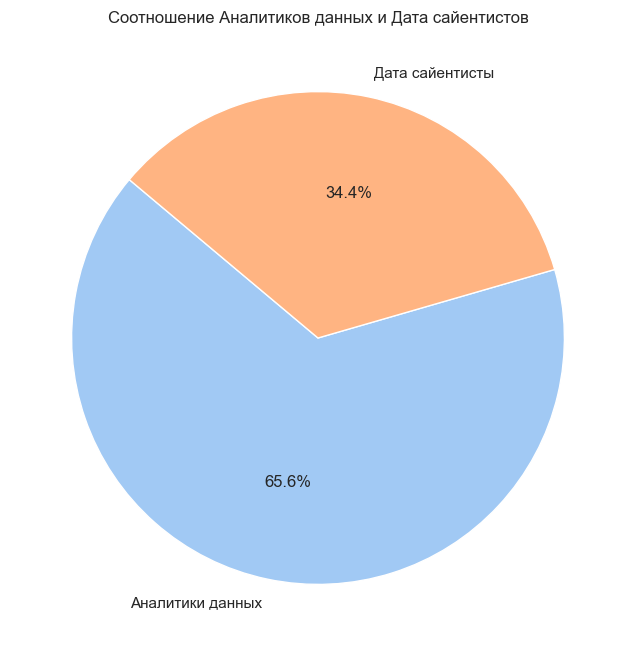

In [24]:
# Подсчет количества каждой категории в столбце 'sourse'
counts = df['source'].value_counts()
# Создание круговой диаграммы
plt.figure(figsize=(12, 8))
plt.pie(counts, labels=['Аналитики данных', 'Дата сайентисты'], autopct='%1.1f%%', startangle=140)
plt.title('Соотношение Аналитиков данных и Дата сайентистов')
plt.show()

Из диаграммы видно, что почти 2/3 вакансий представлено для Аналитиков данных.

Посмотрим в каких городах требуются Аналитики.

In [25]:
df[df.source == 'da'].area.value_counts()[:15]

area
Москва             1215
Санкт-Петербург     174
Екатеринбург         50
Нижний Новгород      33
Новосибирск          32
Владивосток          30
Казань               26
Краснодар            22
Самара               11
Ростов-на-Дону       10
Челябинск            10
Пермь                10
Тюмень                8
Воронеж               8
Владимир              7
Name: count, dtype: int64

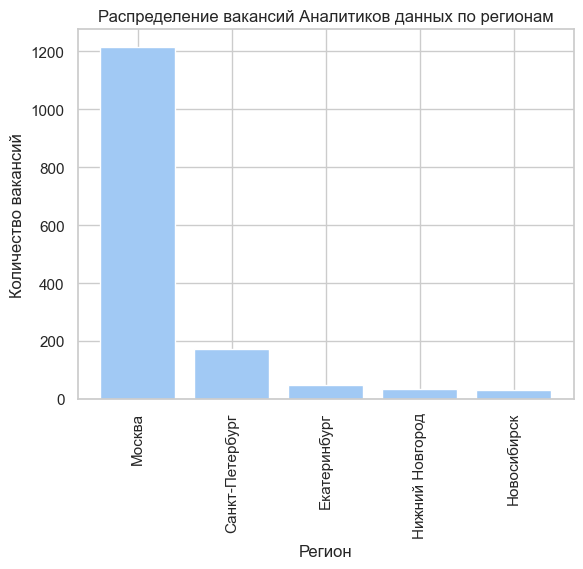

In [26]:
# посмотрим топ 5 регионов в которых размещены вакансии аналитиков данных на графике
area_da = df[df.source == 'da'].area.value_counts()[:5]
area_names = area_da.index
area_counts = area_da.values
plt.figure(dpi=100)
plt.bar(area_names, area_counts)
plt.xlabel('Регион')
plt.ylabel('Количество вакансий')
plt.title('Распределение вакансий Аналитиков данных по регионам')
plt.xticks(rotation=90)
plt.show()

Как и ожидалось, большинство вакансий представлено в Москве (1215), на втором месте - Санкт-Петербург, хотя там вакансий на порядок меньше (174), в остальных же городах вакансий очень мало, буквально единицы.

Теперь все тоже самое посмотрим для дата саентистов.

In [27]:
df[df.source == 'ds'].area.value_counts()[:15]

area
Москва             726
Санкт-Петербург     82
Новосибирск         23
Екатеринбург        18
Нижний Новгород     17
Казань              12
Краснодар            5
Самара               5
Сочи                 4
Томск                4
Тюмень               3
Ижевск               3
Воронеж              3
Тамбов               2
Челябинск            2
Name: count, dtype: int64

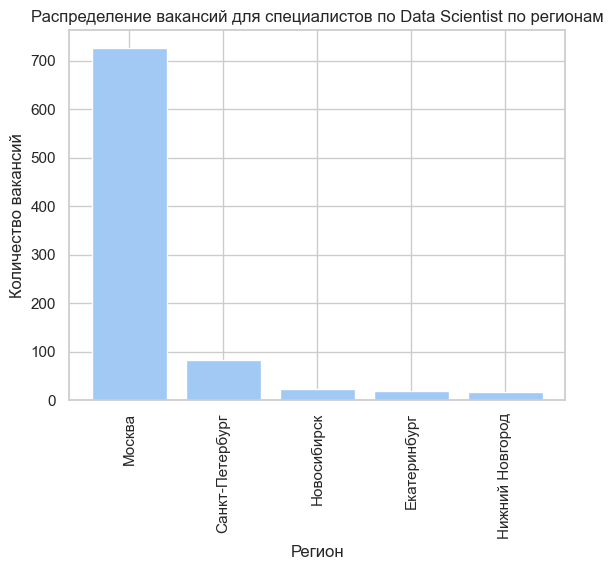

In [28]:
# посмотрим топ 5 регионов в которых размещены вакансии для специалистов по Data Scientist на графике
area_ds = df[df.source == 'ds'].area.value_counts()[:5]
area_names = area_ds.index
area_counts = area_ds.values
plt.figure(dpi=100)
plt.bar(area_names, area_counts)
plt.xlabel('Регион')
plt.ylabel('Количество вакансий')
plt.title('Распределение вакансий для специалистов по Data Scientist по регионам')
plt.xticks(rotation=90)
plt.show()

Тенденция распределения вакансий по регионам схожая, также большинство вакансий размещены в Москве (726), на втором месте Санкт-Петербург и также уступает на порядок (82). Пятерка регионов-лидеров все та же. 

Теперь посмотрим на одном графике, чтобы увидеть каких вакансий больше.

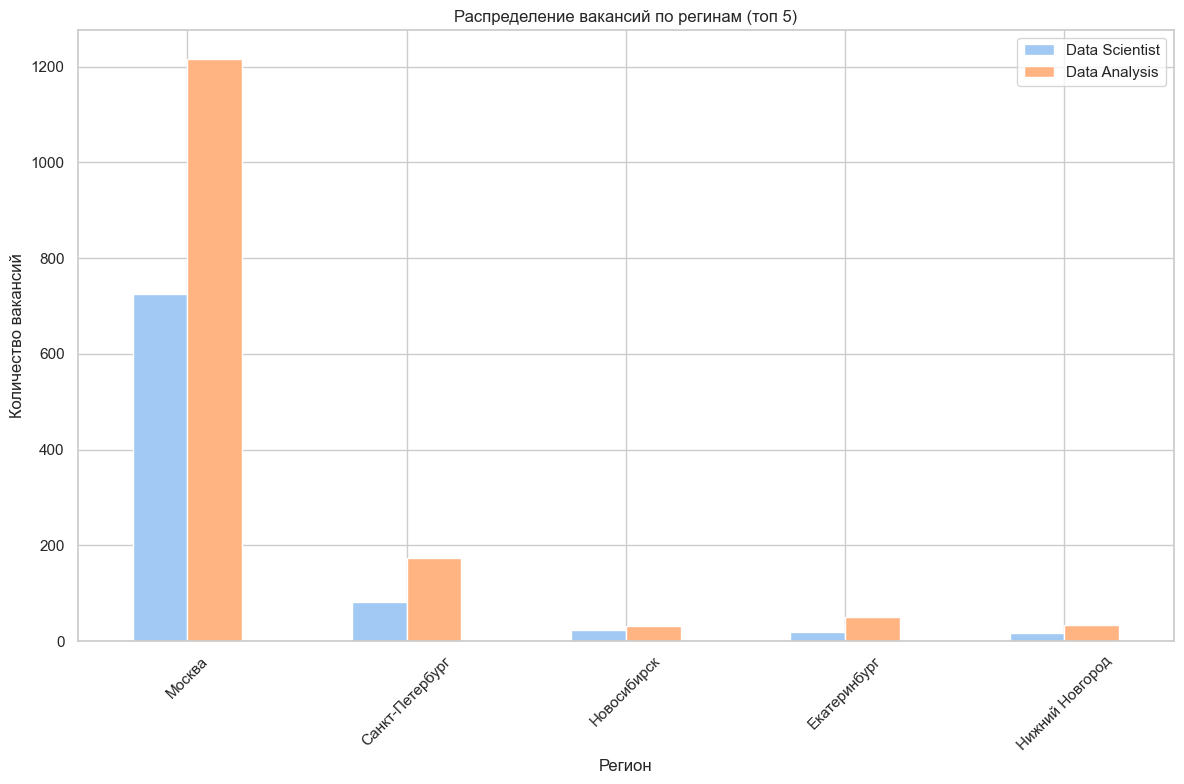

In [29]:
# Объединяем данные для построения на одном графике
area_da_ds = pd.concat([area_ds, area_da], axis=1)


# Строим график
area_da_ds.plot(kind='bar', figsize=(12, 8))
plt.xlabel('Регион')
plt.ylabel('Количество вакансий')
plt.title('Распределение вакансий по регинам (топ 5)')
plt.xticks(rotation=45)  # Поворачиваем подписи по оси x для лучшей читаемости
plt.legend(['Data Scientist', 'Data Analysis'])  # Добавляем легенду
plt.tight_layout()

# Отображаем график
plt.show()

Этот график показывает, что аналитики данных сейчас более востребованы, чем дата сайентисты.

## Выявление грейда требуемых специалистов по названию вакансии или по колонке с требуемым опытом

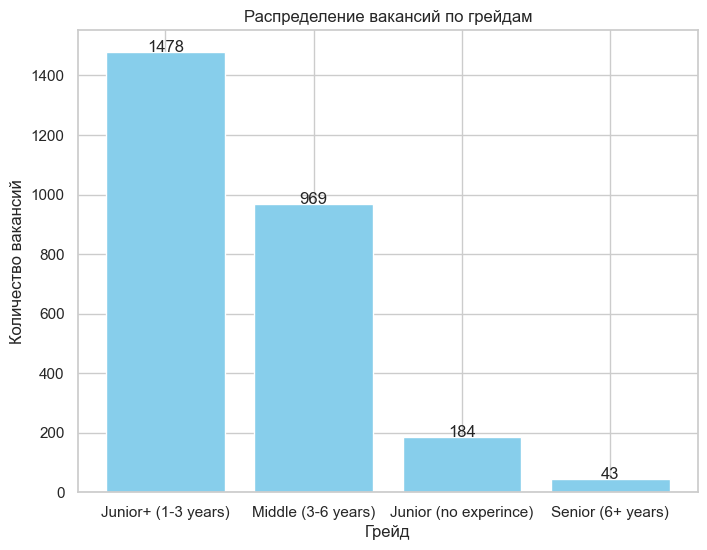

In [30]:
# подсчитаем количество вакансий для каждого грейда
experience_counts = df['experience'].value_counts()

# Построение столбчатой диаграммы
plt.figure(figsize=(8, 6))
plt.bar(experience_counts.index, experience_counts.values, color='skyblue')

# Настройка осей и заголовка
plt.xlabel('Грейд')
plt.ylabel('Количество вакансий')
plt.title('Распределение вакансий по грейдам')

# Отображение значений над столбцами
for i, value in enumerate(experience_counts.values):
    plt.text(i, value + 0.2, str(value), ha='center')

# Отображение графика
plt.show()

В целом больше вакансий для джунов с небольшим опытом, затем идут вакансии мидлов. Посмотрим, сохраняется ли эта тенденция, если рассмотреть вакансии для аналитиков и саентистов отдельно.

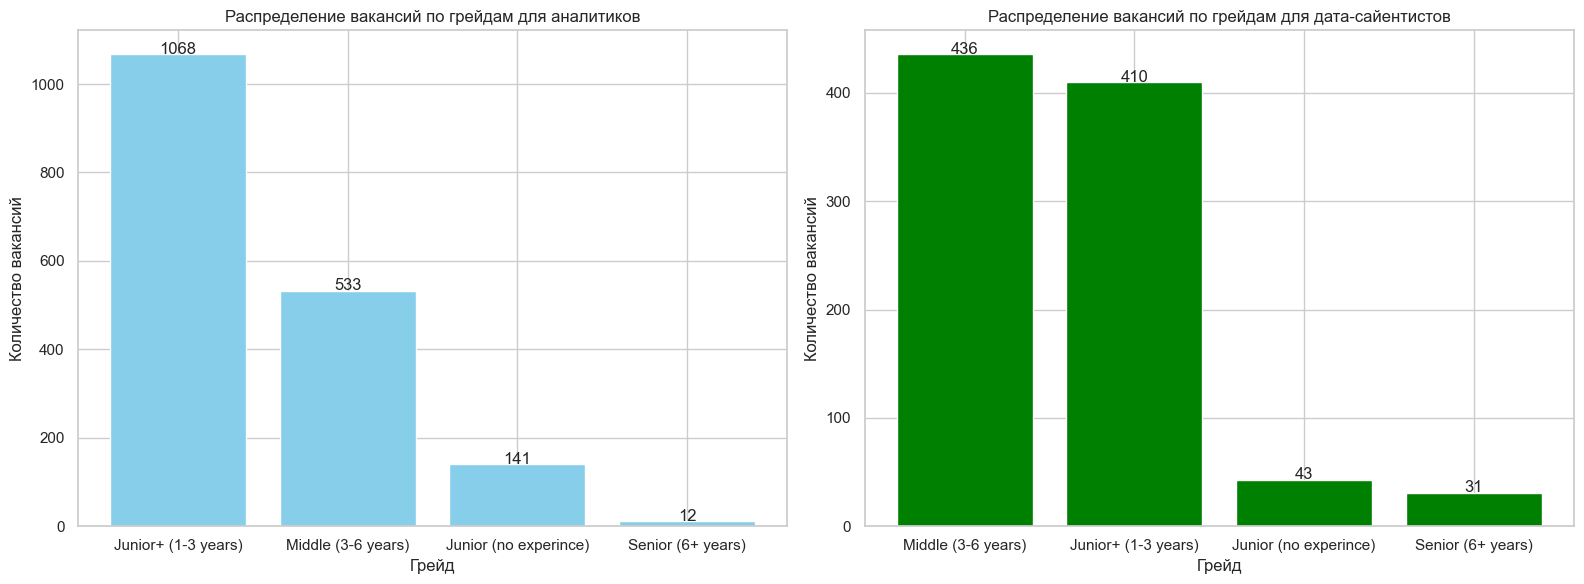

In [31]:
# Подсчитаем количество вакансий для каждого грейда отдельно для аналитиков и дата-сайентистов
experience_counts_analysts = df[df['source'] == 'da']['experience'].value_counts()
experience_counts_datascientists = df[df['source'] == 'ds']['experience'].value_counts()

# Создание фигуры и осей для двух графиков
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График для аналитиков
axes[0].bar(experience_counts_analysts.index, experience_counts_analysts.values, color='skyblue')
axes[0].set_xlabel('Грейд')
axes[0].set_ylabel('Количество вакансий')
axes[0].set_title('Распределение вакансий по грейдам для аналитиков')
for i, value in enumerate(experience_counts_analysts.values):
    axes[0].text(i, value + 0.2, str(value), ha='center')

# График для дата-сайентистов
axes[1].bar(experience_counts_datascientists.index, experience_counts_datascientists.values, color='green')
axes[1].set_xlabel('Грейд')
axes[1].set_ylabel('Количество вакансий')
axes[1].set_title('Распределение вакансий по грейдам для дата-сайентистов')
for i, value in enumerate(experience_counts_datascientists.values):
    axes[1].text(i, value + 0.2, str(value), ha='center')

# Отображение графиков
plt.tight_layout()
plt.show()

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод: </b> 

Аналитики данных:

* среди аналитиков самая востребованная позиция Junior+ с опытом работы 1-3 года, таких вакансий 1068
* следующая по популярности среди аналитиков вакансия Middle с опытом 3-6 лет, таких вакансий 533
* без опыта работы на позицию Junior открыто 141 вакансии
* меньше всего вакансий для позиции Senior - всего 12
  
Датасаентисты:

* среди датасаентистов больше всего вакансий для позиции Middle с опытом 3-6 лет, таких вакансий 436
* следующая по популярности вакансия Junior+ с опытом работы 1-3 года, таких вакансий 410
* без опыта работы на позицию Junior открыто всего 43 вакансии (гораздо меньше чем среди аналитиков)
* на позицию Senior открыта 31 вакансия (больше, чем среди аналитиков)
   </div>

## Определение доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Датасаентистов

Посмотрим распределение долей грейдов отдельно для Аналитиков и Дата саентистов.
Отобразим доли на круговых диаграммах, но чтобы было нагляднее присвоим одинаковым грейдам одинаковый цвет.

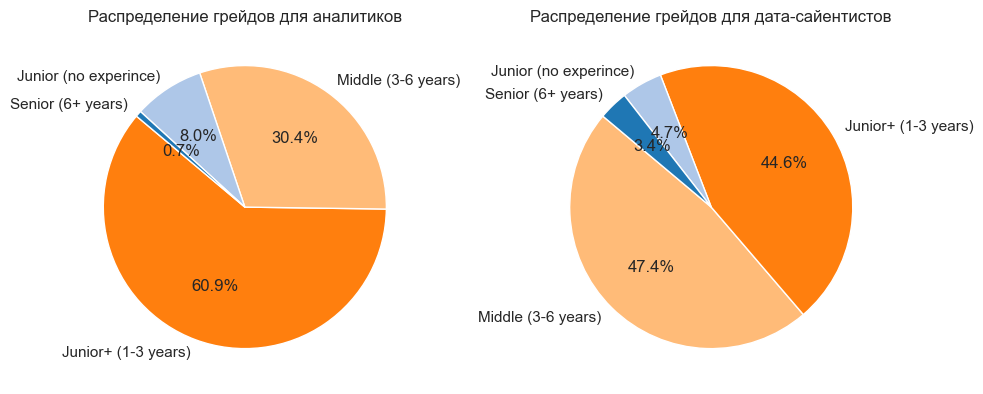

In [32]:
# Разделение данных на аналитиков и дата-сайентистов
analysts = df[df['source'] == 'da']
datascientists = df[df['source'] == 'ds']

# Подсчет количества каждого грейда для аналитиков и дата-сайентистов
analyst_grades = analysts['experience'].value_counts()
datascientist_grades = datascientists['experience'].value_counts()


# Получение уникальных грейдов
unique_grades = list(set(analyst_grades.index).union(set(datascientist_grades.index)))

# Определение цветовой палитры и создание словаря для грейдов
colors = plt.cm.tab20(range(len(unique_grades)))
grade_color_dict = {grade: colors[i] for i, grade in enumerate(unique_grades)}

# Функция для получения цветов на основе грейдов
def get_colors(grades):
    return [grade_color_dict[grade] for grade in grades.index]

# Получение цветов для аналитиков и дата-сайентистов
colors_analysts = get_colors(analyst_grades)
colors_datascientists = get_colors(datascientist_grades)

# Создание фигуры и осей для двух круговых диаграмм
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Круговая диаграмма для аналитиков
axes[0].pie(analyst_grades, labels=analyst_grades.index, autopct='%1.1f%%', startangle=140, colors=colors_analysts)
axes[0].set_title('Распределение грейдов для аналитиков')

# Круговая диаграмма для дата-сайентистов
axes[1].pie(datascientist_grades, labels=datascientist_grades.index, autopct='%1.1f%%', startangle=140, colors=colors_datascientists)
axes[1].set_title('Распределение грейдов для дата-сайентистов')

# Отображение графиков
plt.tight_layout()
plt.show()

Поменяем значения в калонках, уберем информацию об обыте, чтобы дальше удобнее работать

In [33]:
# Словарь для замены значений
replace_dict = {
    'Junior (no experince)': 'Junior',
    'Junior+ (1-3 years)': 'Junior+',
    'Middle (3-6 years)': 'Middle',
    'Senior (6+ years)': 'Senior'
}

# Замена значений
df['experience'] = df['experience'].replace(replace_dict)

# Проверка результата
print(df['experience'].unique())

['Middle' 'Junior+' 'Junior' 'Senior']


Вакансии аналитиков данных:
* самая востребованная позиция (60.9%) - Junior+ с опытом работы от 1 до 3 лет
* в два раза меньше вакансий (30.4%) на позицию Middle с опытом работы 3-6 лет
* позиций для Junior без опыта меньше одной десятой(8%) 
* меньше всего вакансий размещено на Senior с опытом работы более 6 лет (0.7%)

Вакансии дата саентистов:

* самая востребованная позиция (47.4%) - Middle с опытом работы 3-6 лет
* почти столько же вакансий (44.6%) на позицию Junior+ с опытом работы от 1 до 3 лет
* позиций для Junior без опыта 4.7% 
* меньше всего вакансий размещено на Senior с опытом работы более 6 лет (3.4%)


Посмотрим на одном графике каких вакансий больше по грейдам.

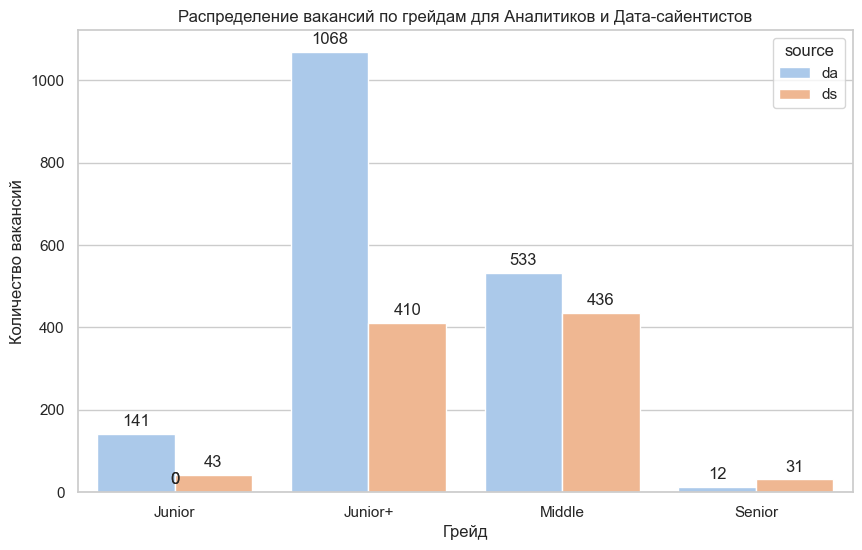

In [34]:
# Подсчитаем количество вакансий для каждого грейда отдельно для аналитиков и дата-сайентистов
experience_counts = df.groupby(['experience', 'source']).size().reset_index(name='count')

# Создание графика
plt.figure(figsize=(10, 6))
sns.barplot(data=experience_counts, x='experience', y='count', hue='source')

# Настройка осей и заголовка
plt.xlabel('Грейд')
plt.ylabel('Количество вакансий')
plt.title('Распределение вакансий по грейдам для Аналитиков и Дата-сайентистов')

# Отображение значений над столбцами
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', xytext=(0, 9), textcoords='offset points')

# Отображение графика
plt.show()

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод: </b> 

* без опыта работы проще найти работу аналитикам данных
* а вот с большим опытом работы наоборот, легче найти работу дата саентистам
* большинство вакансий для Junior+  с опытом работы от 1 до 3 лет
* на позицию Middle больше процент вакансий у дата сантистов </div>

## Определение типичного места работы для Аналитика данных и Датасаентиста по следующим параметрам: ТОП-работодателей по числу вакансий, зарплата, тип занятости, график работы. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.

### ТОП работодателей

Посмотрим на ТОП работодателей по грейдам для Аналитиков и Дата саентистов

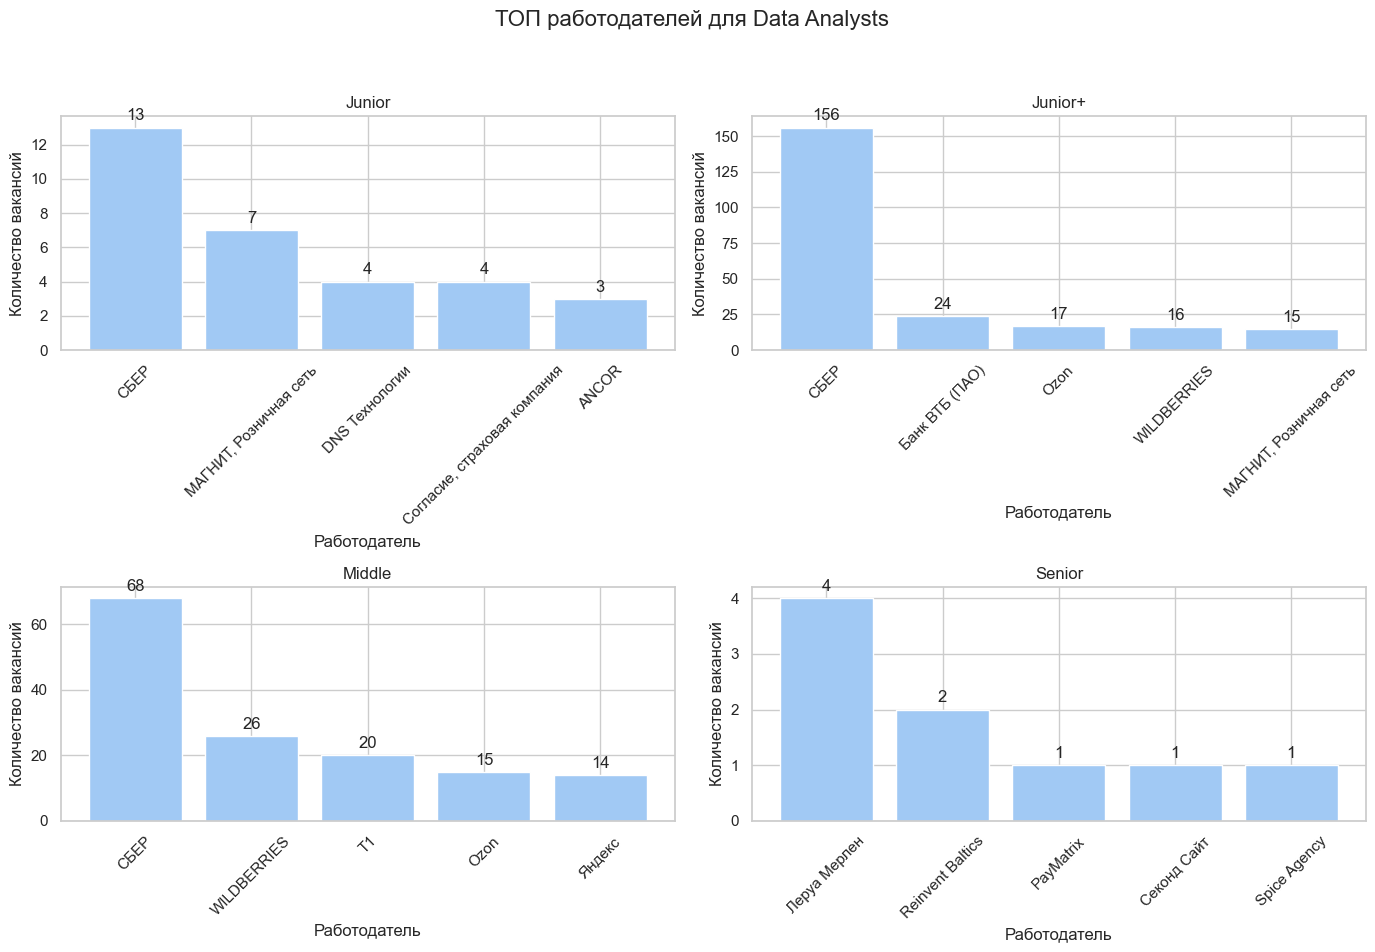

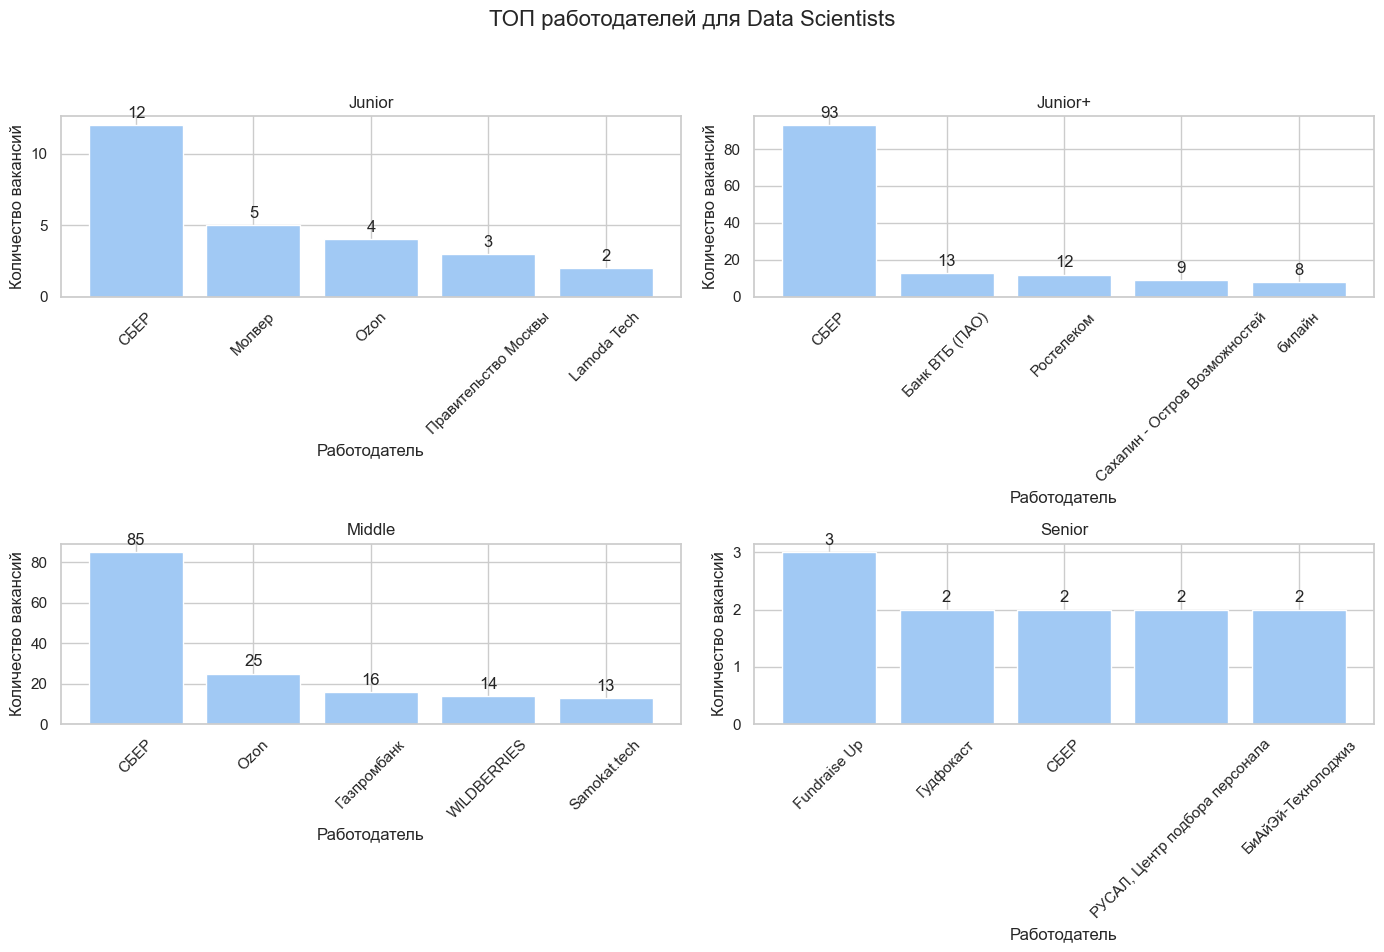

In [35]:
# Функция для получения ТОП-работодателей по числу вакансий для каждого грейда
def get_top_employers(df, position):
    result = {}
    for grade in ['Junior', 'Junior+', 'Middle', 'Senior']:
        subset = df[(df['source'] == position) & (df['experience'] == grade)]
        if subset.empty:
            result[grade] = pd.DataFrame(columns=['Employer', 'Vacancies'])
            continue
        
        top_employers = subset['employer'].value_counts().head(5).reset_index()
        top_employers.columns = ['Employer', 'Vacancies']
        
        result[grade] = top_employers
    
    return result

# Получение ТОП-работодателей для Data Analyst (da) и Data Scientist (ds)
top_employers_da = get_top_employers(df, 'da')
top_employers_ds = get_top_employers(df, 'ds')

# Функция для построения барчартов с добавлением значений вакансий над столбцами
def plot_bar_charts(top_employers, position):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'ТОП работодателей для {position}', fontsize=16)
    
    grades = ['Junior', 'Junior+', 'Middle', 'Senior']
    axes = axes.flatten()
    
    for i, grade in enumerate(grades):
        ax = axes[i]
        table = top_employers[grade]
        
        if not table.empty:
            bars = ax.bar(table['Employer'], table['Vacancies'])
            ax.set_title(f'{grade}')
            ax.set_xlabel('Работодатель')
            ax.set_ylabel('Количество вакансий')
            ax.tick_params(axis='x', rotation=45)
            
            # Добавление значений над столбцами
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height}', 
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3), 
                            textcoords="offset points",
                            ha='center', va='bottom')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Построение барчартов
plot_bar_charts(top_employers_da, 'Data Analysts')
plot_bar_charts(top_employers_ds, 'Data Scientists')

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод поработодателям: </b> 

* из графиков видно, что компании разные не только для Аналитиков и Дата саентивстов, но и в зависимости от грейда
* единственная стабильно повторяющаяся компания - СБЕР
* при этом по количеству размещенных вакансий, СБЕР ищет больше Аналитиков, чем Дата саентистов
* большинство вакансий как для Аналитиков, так и для Дата саентистов для джунов с небольшим опытом работы и миддлов
* вакансий для джунов без опыта и сеньоров очень мало
* Аналитикам без опыта работы найти вакансию немного проще, чем Дата саентистам
* позицией сеньор ровно наоборот, их чуть больше среди вакансий для Дата саентистов </div>

### Зарплата

Перейдем к зарплате. Мы помним, что информации о зарплате было очень мало, но посмотрим на то что есть. 
Выведем среднюю рарплату, которая указана в зарплатной вилке.

In [36]:
# Функция для расчета средней зарплаты
def average_salary_by_grade(df, source):
    grades = ['Junior', 'Junior+', 'Middle', 'Senior']
    average_salaries = {}
    for grade in grades:
        filtered_df = df[(df['source'] == source) & (df['experience'] == grade)]
        filtered_salaries = filtered_df[['salary_from', 'salary_to']].stack().dropna()
        average_salaries[grade] = round(filtered_salaries.mean())
    return average_salaries

# Расчет средней зарплаты для аналитиков данных и дата-саентистов
average_salary_analysts = average_salary_by_grade(df, 'da')
average_salary_datascientists = average_salary_by_grade(df, 'ds')

# Вывод результатов
print("Средняя зарплата для аналитиков данных:")
for grade, salary in average_salary_analysts.items():
    print(f"Грейд {grade}: {salary}")

print("\nСредняя зарплата для дата-саентистов:")
for grade, salary in average_salary_datascientists.items():
    print(f"Грейд {grade}: {salary}")

Средняя зарплата для аналитиков данных:
Грейд Junior: 67962
Грейд Junior+: 110528
Грейд Middle: 206600
Грейд Senior: 190000

Средняя зарплата для дата-саентистов:
Грейд Junior: 74596
Грейд Junior+: 189162
Грейд Middle: 288213
Грейд Senior: 300000


В целом данные похожи на правду, но смущает, что среди вакансий аналитиков сеньоры получают меньше мидлов.
Посмотрим на категории зарплат.

In [37]:
# Фильтрация данных для аналитиков и дата-саентистов
analysts = df[df['source'] == 'da']
datascientists = df[df['source'] == 'ds']

# Вывод частоты значений категорий зарплат для аналитиков с разбивкой по грейдам
print("Категории зарплат для аналитиков:")
print(analysts.groupby('experience')['salary_bin'].value_counts())

# Вывод частоты значений категорий зарплат для дата-саентистов с разбивкой по грейдам
print("\nКатегории зарплат для дата-саентистов:")
print(datascientists.groupby('experience')['salary_bin'].value_counts())

Категории зарплат для аналитиков:
experience  salary_bin               
Junior      ЗП не указана                107
            Меньше 100 тысяч              29
            От 100 тысяч до 200 тысяч      5
Junior+     ЗП не указана                940
            От 100 тысяч до 200 тысяч     72
            Меньше 100 тысяч              33
            От 200 тысяч до 300 тысяч     21
            Больше 300 тысяч               2
Middle      ЗП не указана                478
            Больше 300 тысяч              24
            От 100 тысяч до 200 тысяч     18
            От 200 тысяч до 300 тысяч      9
            Меньше 100 тысяч               4
Senior      ЗП не указана                 10
            От 200 тысяч до 300 тысяч      2
Name: count, dtype: int64

Категории зарплат для дата-саентистов:
experience  salary_bin               
Junior      ЗП не указана                 39
            Меньше 100 тысяч               3
            От 100 тысяч до 200 тысяч      1
Junior+     ЗП

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод по зарплатам: </b> 

* в среднем аналитики любого грейда получают чуть меньше, чем датасаентисты соответствующего грейда
* джуны получают меньше 100 тысяч в обоих случаях, зарплаты не сильно отличаются
* джуны с опытом среди дата саентистов получают больше, чем среди аналитиков больше чем в 1,5 раза
* среди мидлов тенденция сохраняется - датасаентисты получают больше, но уже менее чем в 1,5 раза
* сеньоры среди аналитиков получают около 190 тысяч, а среди датасаентистов 300 тысяч, но данных очень мало, чтобы делать однозначные выводы </div>

### Тип занятости

Рассмотрим тип занятости по грейдам. Сначала взглянем на аналитиков данных.

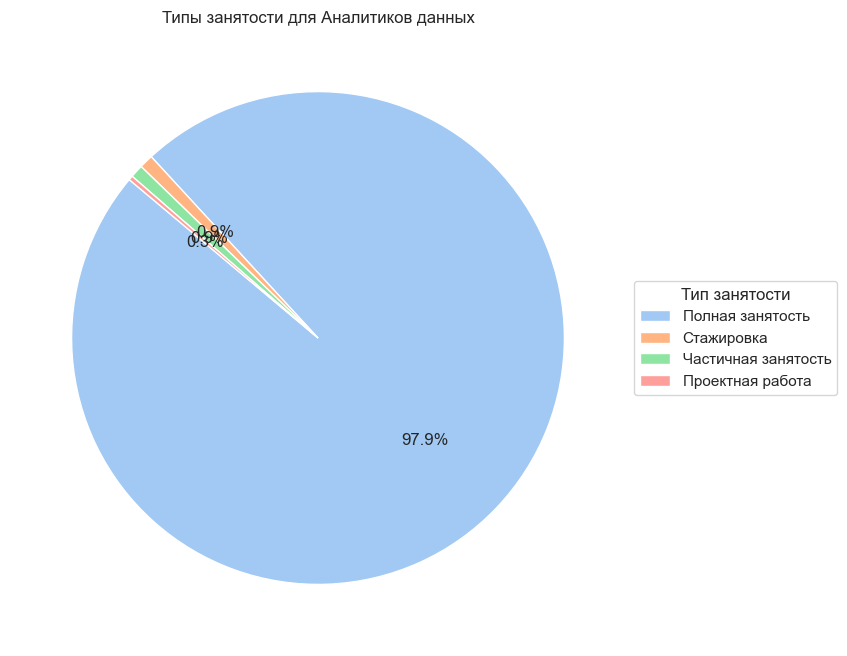

In [38]:
# Фильтрация данных для аналитиков данных
analysts_df = df[df['source'] == 'da']

# Подсчет количества каждого типа занятости
employment_counts = analysts_df['employment'].value_counts()

# Создание пайчарта
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(employment_counts, autopct='%1.1f%%', startangle=140)

# Настройка легенды
ax.legend(wedges, employment_counts.index, title="Тип занятости", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Типы занятости для Аналитиков данных')
plt.show()

Теперь посмотрим с разбивкой по грейдам.

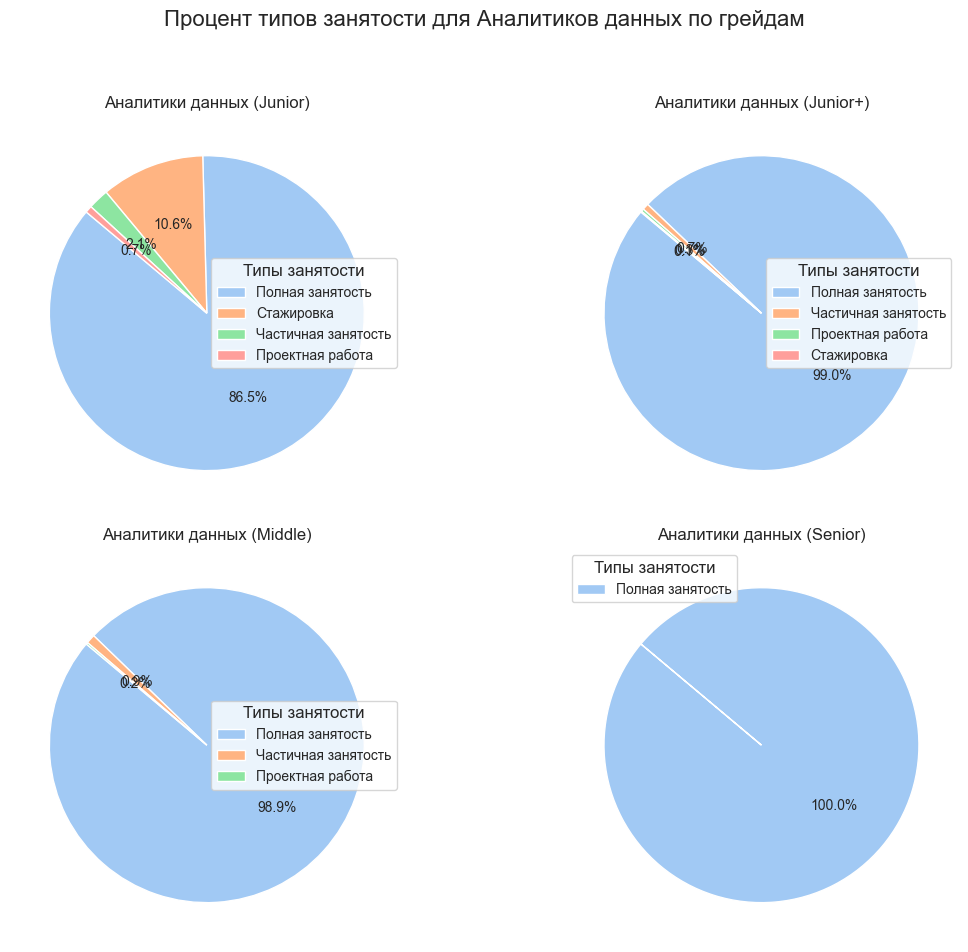

In [39]:
# Создание сабплотов для каждого грейда
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Список грейдов
grades = ['Junior', 'Junior+', 'Middle', 'Senior']

# Проход по каждому грейду
for i, grade in enumerate(grades):
    da_data = df[(df['source'] == 'da') & (df['experience'] == grade)]
    
    # Подсчет процентов типов занятости для аналитиков
    da_counts = da_data['employment'].value_counts(normalize=True) * 100
    
    # Построение пайчарта для аналитиков
    wedges, _, autotexts = axes[i//2, i%2].pie(da_counts, labels=None, autopct='%1.1f%%', startangle=140)
    axes[i//2, i%2].set_title(f'Аналитики данных ({grade})')
    
    # Создание легенды
    axes[i//2, i%2].legend(labels=da_counts.index, loc="best", fontsize='small', title="Типы занятости")

    # Настройка размера шрифта подписей
    for autotext in autotexts:
        autotext.set_fontsize(10)

# Установка общего заголовка для всех подграфиков
fig.suptitle('Процент типов занятости для Аналитиков данных по грейдам', fontsize=16)

# Установка отступов между графиками
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Отображение графиков
plt.show()

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод по типам занятости аналитиков данных: </b> 

* практически для всех грейдов тип занятости - полная занятость
* только среди вакансий для джунов етсь 10% стажировки
* остальные типы занятости почти не встречаются </div>

Перейдем к датасаентистам

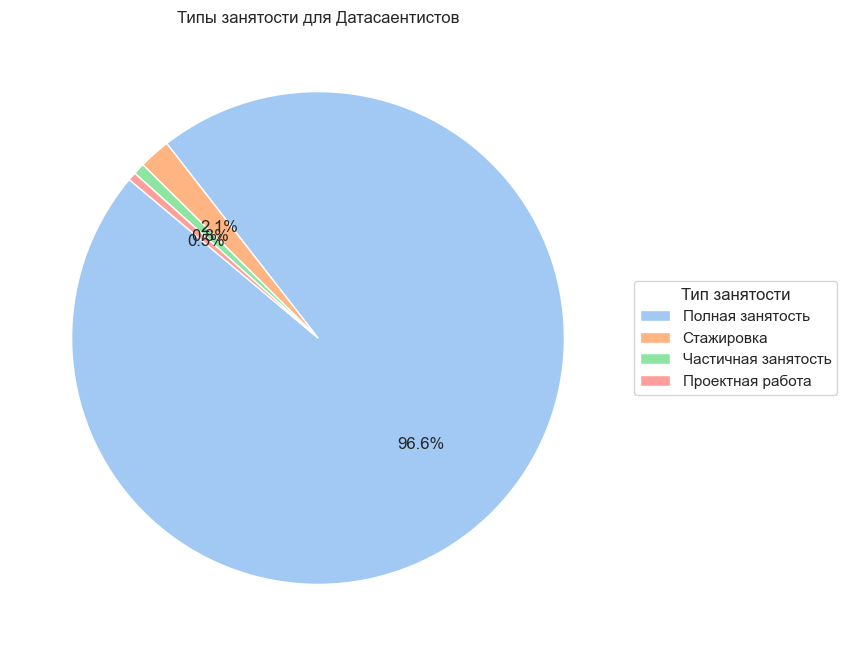

In [40]:
# Фильтрация данных для аналитиков данных
analysts_df = df[df['source'] == 'ds']

# Подсчет количества каждого типа занятости
employment_counts = analysts_df['employment'].value_counts()

# Создание пайчарта
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(employment_counts, autopct='%1.1f%%', startangle=140)

# Настройка легенды
ax.legend(wedges, employment_counts.index, title="Тип занятости", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Типы занятости для Датасаентистов')
plt.show()

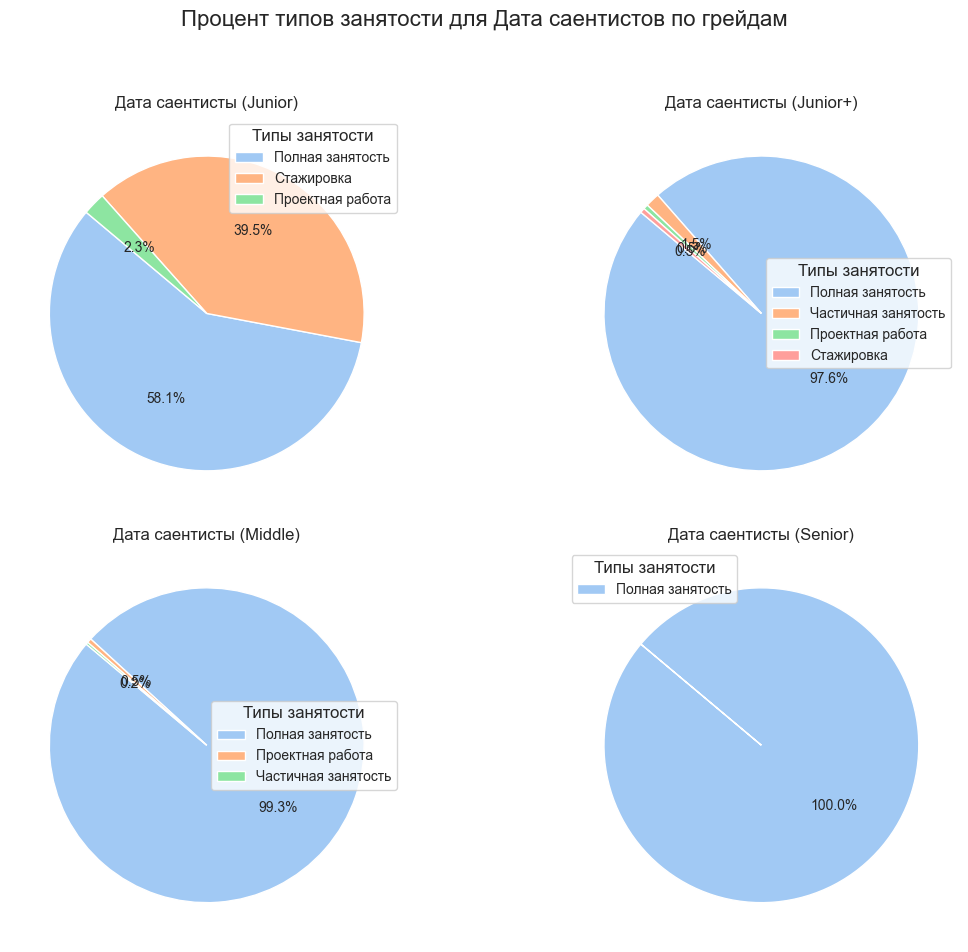

In [41]:
# Создание сабплотов для каждого грейда
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Список грейдов
grades = ['Junior', 'Junior+', 'Middle', 'Senior']

# Проход по каждому грейду
for i, grade in enumerate(grades):
    da_data = df[(df['source'] == 'ds') & (df['experience'] == grade)]
    
    # Подсчет процентов типов занятости для датасаентистов
    da_counts = da_data['employment'].value_counts(normalize=True) * 100
    
    # Построение пайчарта для датасаентистов
    wedges, _, autotexts = axes[i//2, i%2].pie(da_counts, labels=None, autopct='%1.1f%%', startangle=140)
    axes[i//2, i%2].set_title(f'Дата саентисты ({grade})')
    
    # Создание легенды
    axes[i//2, i%2].legend(labels=da_counts.index, loc="best", fontsize='small', title="Типы занятости")

    # Настройка размера шрифта подписей
    for autotext in autotexts:
        autotext.set_fontsize(10)

# Установка общего заголовка для всех подграфиков
fig.suptitle('Процент типов занятости для Дата саентистов по грейдам', fontsize=16)

# Установка отступов между графиками
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Отображение графиков
plt.show()

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод по типам занятости дата саентистов: </b> 

* для сеньоров, мидлов и аналитиков с опытом картина такая же как и у аналитиков - полная занятость
* среди вакансий для джунов процент стажировок выше - почти 40% </div>

### График работы

Теперь посмотрим на графики работы в том же порядке. Сначала для аналитиков данных

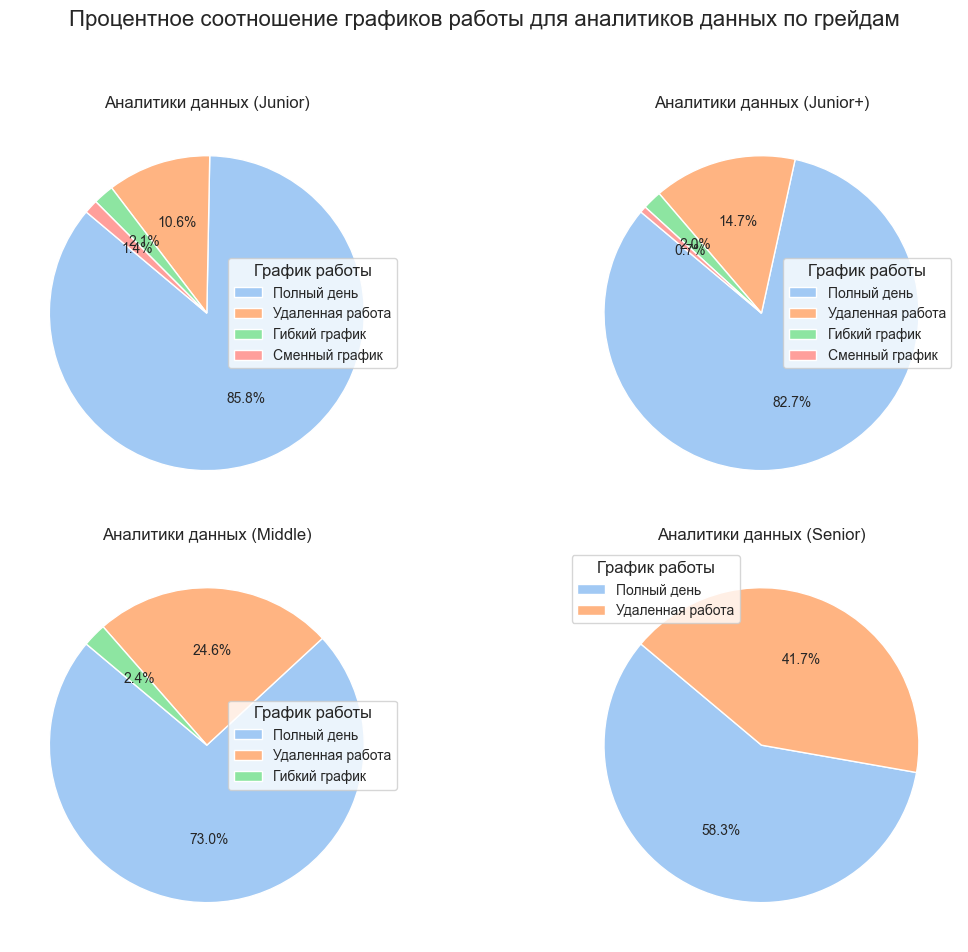

In [42]:
# Создание сабплотов для каждого грейда
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Список грейдов
grades = ['Junior', 'Junior+', 'Middle', 'Senior']

# Проход по каждому грейду
for i, grade in enumerate(grades):
    da_data = df[(df['source'] == 'da') & (df['experience'] == grade)]
    
    # Подсчет процентов типов занятости для аналитиков
    da_counts = da_data['schedule'].value_counts(normalize=True) * 100
    
    # Построение пайчарта для аналитиков
    wedges, _, autotexts = axes[i//2, i%2].pie(da_counts, labels=None, autopct='%1.1f%%', startangle=140)
    axes[i//2, i%2].set_title(f'Аналитики данных ({grade})')
    
    # Создание легенды
    axes[i//2, i%2].legend(labels=da_counts.index, loc="best", fontsize='small', title="График работы")

    # Настройка размера шрифта подписей
    for autotext in autotexts:
        autotext.set_fontsize(10)

# Установка общего заголовка для всех подграфиков
fig.suptitle('Процентное соотношение графиков работы для аналитиков данных по грейдам', fontsize=16)

# Установка отступов между графиками
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Отображение графиков
plt.show()

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод по графикам работы аналитиков: </b> 

* самый высокий процент вакансий с удаленной работой среди сеньоров - почти 42%, остальные 58% - полный день
* у мидлов процент вакансий с удаленной работой составляет 24%, в 10 раз меньше вакансий с гибким графиком, остальные 73% - полный день
* для джунов+ доля вакансий с удаленной работой составляет почти 15%, 2% гибкого графика и меньше 1% сменного графика
* для джунов без опыта всего 10% удаленной работы, и по паре процентов гибкого и сменного графика
    </div>

Взглянем на картину у Дата саентистов

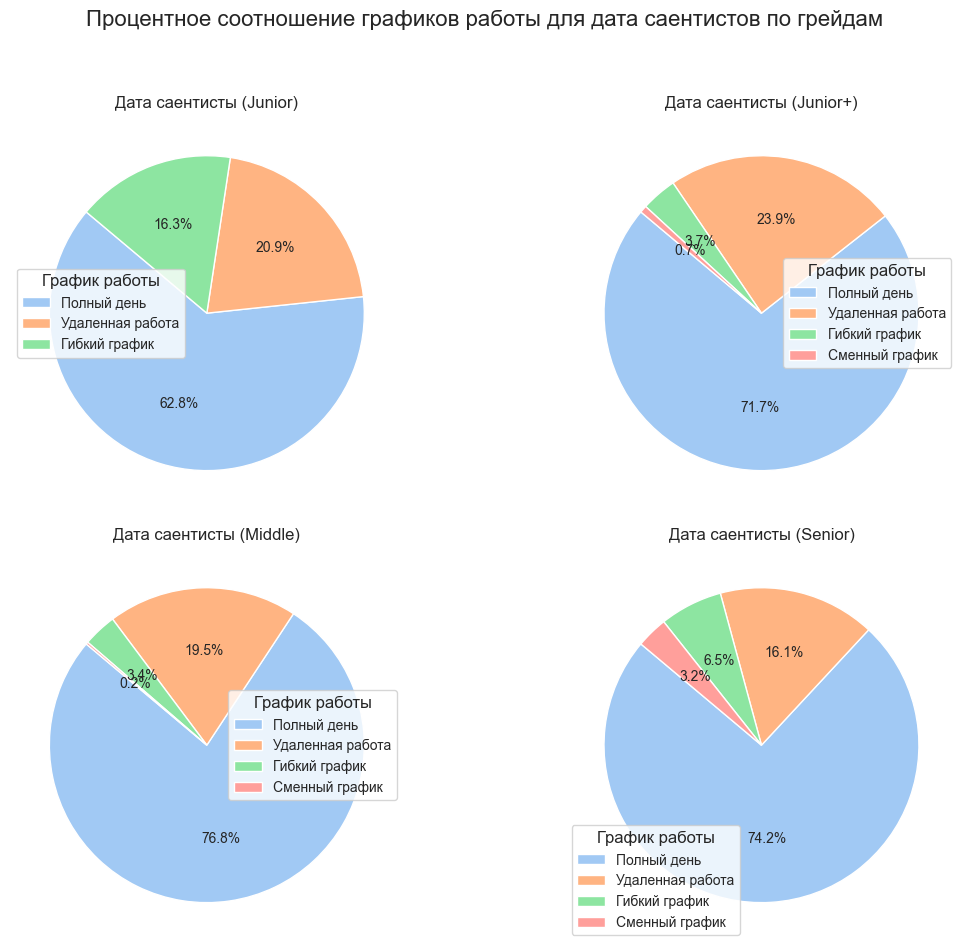

In [43]:
# Создание сабплотов для каждого грейда
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Список грейдов
grades = ['Junior', 'Junior+', 'Middle', 'Senior']

# Проход по каждому грейду
for i, grade in enumerate(grades):
    da_data = df[(df['source'] == 'ds') & (df['experience'] == grade)]
    
    # Подсчет процентов типов занятости для дата саентистов
    da_counts = da_data['schedule'].value_counts(normalize=True) * 100
    
    # Построение пайчарта для дата саентистов
    wedges, _, autotexts = axes[i//2, i%2].pie(da_counts, labels=None, autopct='%1.1f%%', startangle=140)
    axes[i//2, i%2].set_title(f'Дата саентисты ({grade})')
    
    # Создание легенды
    axes[i//2, i%2].legend(labels=da_counts.index, loc="best", fontsize='small', title="График работы")

    # Настройка размера шрифта подписей
    for autotext in autotexts:
        autotext.set_fontsize(10)

# Установка общего заголовка для всех подграфиков
fig.suptitle('Процентное соотношение графиков работы для дата саентистов по грейдам', fontsize=16)

# Установка отступов между графиками
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Отображение графиков
plt.show()

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод по графикам работы дата саентистов: </b> 

* самый высокий процент вакансий с удаленной работой среди вакансий джун+ - почти 24%, 3% гибкого графика, остальное - полный день
* у джунов без опыта процент вакансий с удаленной работой почти такой же 21%, а вот вакансий с гибким графиком 16%, остальные 63% - полный день
* для мидлов доля вакансий с удаленной работой составляет почти 19,5% и 3,4% гибкого графика 
* среди вакансий сеньоров всего 16% удаленной работы, 6,5% гибкого и 3% сменного графика
    </div>

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Усредненная картина типичного места работы </b> 

---
📝 <b>Аналитики данных</b>

---

<div class="alert alert-info"> <b>✔️Junior:</b> </div>
    
* <b>Топ работодателей:</b> СБЕР, Магнит, DNS, Согласие(страховая компания), ANCOR

* <b>Средняя заработная плата:</b> около 68 тысяч рублей

* <b>Тип занятости:</b> 11% - стажировка, 89% - полная занятость

* <b>График работы:</b> 11% - удаленная работа, 89% - полный день


<div class="alert alert-block alert-success"><b>✔️Junior+:</b> </div>
    
* <b>Топ работодателей:</b> СБЕР, Банк ВТБ, OZON, WILDBERRIES, Магнит

* <b>Средняя заработная плата:</b> около 110 тысяч рублей

* <b>Тип занятости:</b> полная занятость

* <b>График работы:</b> 15% - удаленная работа, 85% - полный день


<div class="alert alert-block alert-warning"><b>✔️Middle:</b> </div>
    
* <b>Топ работодателей:</b> СБЕР, WILDBERRIES, T1, OZON, Яндекс

* <b>Средняя заработная плата:</b> около 210 тысяч рублей

* <b>Тип занятости:</b> полная занятость

* <b>График работы:</b> 25% - удаленная работа, 75% - полный день


<div class="alert alert-block alert-danger"><b>✔️Senior:</b> </div>
    
* <b>Топ работодателей:</b> Леруа мерлен, Reinvent Baltics, PayMatrix, Секонд Сайт, Spice Agency

* <b>Средняя заработная плата:</b> около 190 тысяч рублей

* <b>Тип занятости:</b> полная занятость

* <b>График работы:</b> 42% - удаленная работа, 58% - полный день

    
---

📝 <b>Дата саентисты</b>

---

<div class="alert alert-info"> <b>✔️Junior:</b>  </div>
    
* <b>Топ работодателей:</b> СБЕР, Молвер, OZON, Правительство Москвы, Lamoda Tech

* <b>Средняя заработная плата:</b> около 75 тысяч рублей

* <b>Тип занятости:</b> 40% - стажировка, 60% - полная занятость

* <b>График работы:</b> 21% - удаленная работа, 16% - гибкий график, 63% - полный день


<div class="alert alert-block alert-success"><b>✔️Junior+:</b> </div>
    
* <b>Топ работодателей:</b> СБЕР, Банк ВТБ, Ростелеком, Сахалин - Остров Возможностей, Билайн

* <b>Средняя заработная плата:</b> около 190 тысяч рублей

* <b>Тип занятости:</b> полная занятость

* <b>График работы:</b> 24% - удаленная работа, 4% - гибкий график, 71% - полный день


<div class="alert alert-block alert-warning"><b>✔️Middle:</b> </div>
    
* <b>Топ работодателей:</b> СБЕР, OZON, Газпромбанк, WILDBERRIES, Samokat.tech

* <b>Средняя заработная плата:</b> около 290 тысяч рублей

* <b>Тип занятости:</b> полная занятость

* <b>График работы:</b> 20% - удаленная работа, 4% - гибкий график, 76% - полный день


<div class="alert alert-block alert-danger"><b>✔️Senior:</b> </div>
    
* <b>Топ работодателей:</b> Fundraise Up, Гудфокаст, СБЕР, РУСАЛ, БиАйЭй-Технолоджиз

* <b>Средняя заработная плата:</b> около 300 тысяч рублей

* <b>Тип занятости:</b> полная занятость

* <b>График работы:</b> 16% - удаленная работа, 6,5% - гибкий график, 3,5% - сменный график, 74% - полный день
</div>
    
---
</div>

## Определение, какие навыки спрашивают чаще - твердые или мягкие. К какому грейду и к какой специальности требований больше.

Для того чтобы определить, какие навыки, мягкие или твердые, спрашивают чаще, и к какому грейду и специальности требований больше, мы можем выполнить следующие шаги:

* Подсчитать количество упоминаний мягких и твердых навыков для каждой записи.
* Сгруппировать данные по грейду и специальности и посчитать сумму упоминаний навыков.
* Сравнить суммы для мягких и твердых навыков.

,source,experience,soft_skills_count,hard_skills_count,total_skills,more_hard_skills,most_requirements
0,da,Junior,13,162,175,True,False
1,da,Junior+,62,1748,1810,True,True
2,da,Middle,24,1041,1065,True,False
3,da,Senior,2,38,40,True,False
4,ds,Junior,3,53,56,True,False
5,ds,Junior+,17,741,758,True,False
6,ds,Middle,13,802,815,True,False
7,ds,Senior,2,45,47,True,False


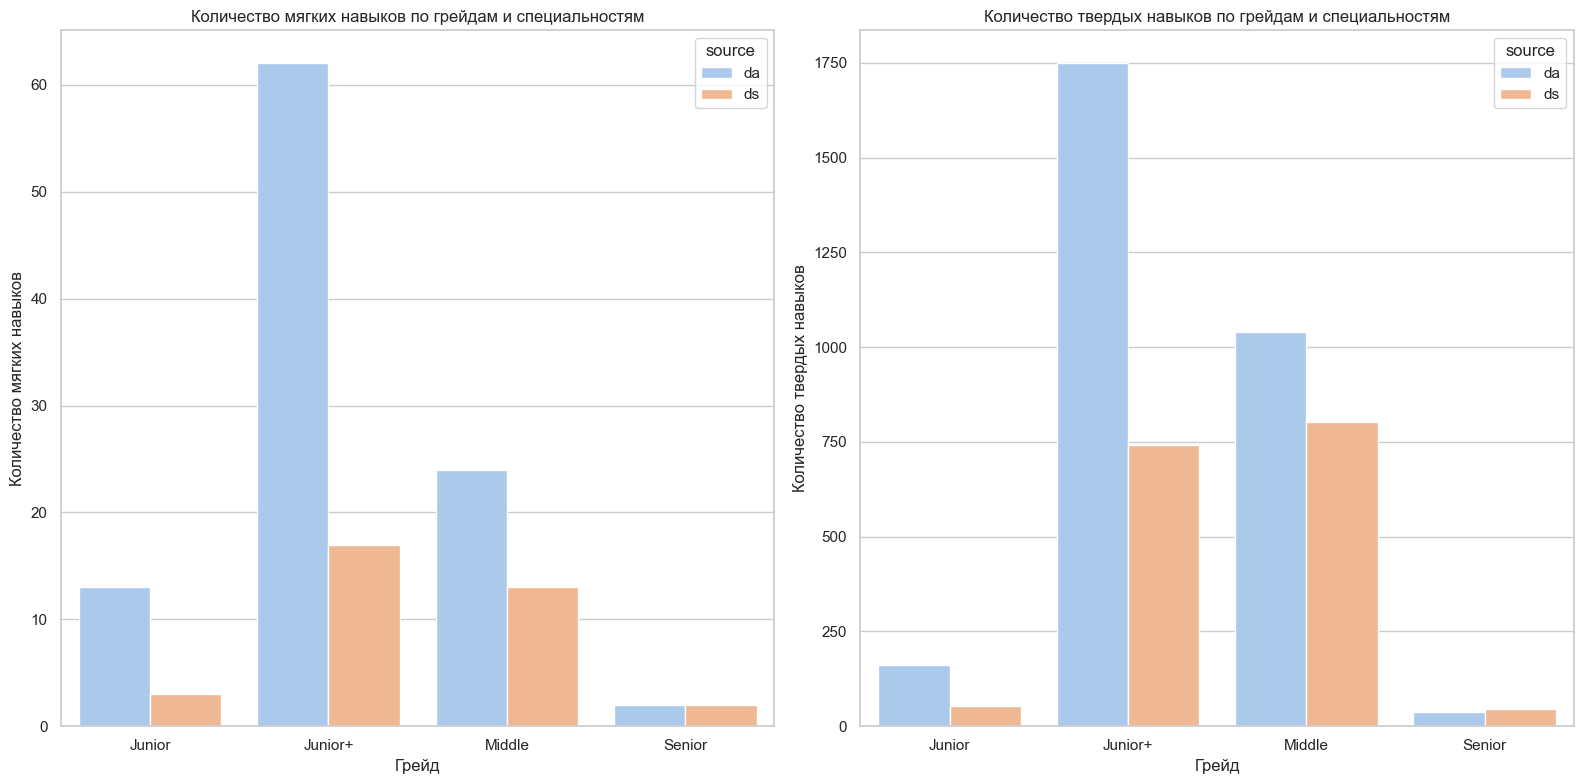

In [44]:
# Подсчет количества мягких и твердых навыков
df['soft_skills_count'] = df['soft_skills'].apply(len)
df['hard_skills_count'] = df['hard_skills'].apply(len)

# Группировка данных по грейду и специальности и подсчет суммы навыков
grouped = df.groupby(['source', 'experience']).agg({
    'soft_skills_count': 'sum',
    'hard_skills_count': 'sum'
}).reset_index()

# Вычисление общего количества навыков для каждой группы
grouped['total_skills'] = grouped['soft_skills_count'] + grouped['hard_skills_count']

# Определение, какие навыки (мягкие или твердые) спрашивают чаще
grouped['more_hard_skills'] = grouped['hard_skills_count'] > grouped['soft_skills_count']

# Определение, к какому грейду и специальности требований больше
grouped['most_requirements'] = grouped['total_skills'] == grouped['total_skills'].max()

# Вывод результатов
display(grouped)

# Построение барчартов
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Барчарт для количества мягких и твердых навыков по грейдам и специальностям
sns.barplot(x='experience', y='soft_skills_count', hue='source', data=grouped, ax=axes[0])
axes[0].set_title('Количество мягких навыков по грейдам и специальностям')
axes[0].set_xlabel('Грейд')
axes[0].set_ylabel('Количество мягких навыков')

sns.barplot(x='experience', y='hard_skills_count', hue='source', data=grouped, ax=axes[1])
axes[1].set_title('Количество твердых навыков по грейдам и специальностям')
axes[1].set_xlabel('Грейд')
axes[1].set_ylabel('Количество твердых навыков')

plt.tight_layout()
plt.show()

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод: </b> 

* Твердые навыки, предсказуемо, спрашивают чаще, чем мягкие
* Больше всего требований позиции June+
* Среди аналитиков больше твердых навыков спрашивают так же у June+
* А вот среди датасаентистов твердых навыков спрашивают больше у позиции Middle
</div>

## Определение наиболее желаемых кандидатов на вакансии Аналитик данных и Дата саентистов по следующим параметрам: самые важные hard-skils, самые важные soft-skils. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.


Для определения наиболее желаемых кандидатов на вакансии Аналитик данных и Дата саентистов мы посмотрим скилы, которые встречаются в требованиях чаще всего.

In [45]:
def get_most_common_skills(skills_list):
    skills_flat = [skill for sublist in skills_list for skill in sublist]
    skills_counter = Counter(skills_flat)
    return skills_counter.most_common(3)

def analyze_skills(df, role, grade):
    df_filtered = df[(df['source'] == role) & (df['experience'] == grade)]
    soft_skills = df_filtered['soft_skills'].tolist()
    hard_skills = df_filtered['hard_skills'].tolist()

    most_common_soft_skills = get_most_common_skills(soft_skills)
    most_common_hard_skills = get_most_common_skills(hard_skills)

    return most_common_soft_skills, most_common_hard_skills

roles = ['da', 'ds']
grades = ['Junior', 'Junior+', 'Middle', 'Senior']

for role in roles:
    for grade in grades:
        soft_skills, hard_skills = analyze_skills(df, role, grade)
        role_name = 'Аналитик данных' if role == 'da' else 'Дата-сайентист'
        print(f"{role_name} ({grade})")
        print("Самые важные soft-skills:", soft_skills)
        print("Самые важные hard-skills:", hard_skills)
        print()


Аналитик данных (Junior)
Самые важные soft-skills: [('работа в команде', 6), ('английский язык', 5), ('подготовка презентаций', 2)]
Самые важные hard-skills: [('sql', 37), ('python', 33), ('ms excel', 28)]

Аналитик данных (Junior+)
Самые важные soft-skills: [('английский язык', 26), ('подготовка презентаций', 19), ('работа в команде', 17)]
Самые важные hard-skills: [('sql', 459), ('python', 311), ('ms excel', 140)]

Аналитик данных (Middle)
Самые важные soft-skills: [('подготовка презентаций', 11), ('английский язык', 9), ('работа в команде', 4)]
Самые важные hard-skills: [('sql', 242), ('python', 204), ('power bi', 72)]

Аналитик данных (Senior)
Самые важные soft-skills: [('английский язык', 2)]
Самые важные hard-skills: [('sql', 9), ('python', 8), ('power bi', 4)]

Дата-сайентист (Junior)
Самые важные soft-skills: [('английский язык', 3)]
Самые важные hard-skills: [('python', 16), ('математическая статистика', 8), ('git', 6)]

Дата-сайентист (Junior+)
Самые важные soft-skills: [('ан

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод: </b> 

* если говорить о soft-skills, то везде требуется знание английского
* важным софт скилом для аналитика является умение подготовки презентаций
* конмандная работа ценится в обеих сферах
* самые важные hard-skills для аналитика это SQL, Python, MS Excel и Power BI
* самые важные hard-skills для дата саентиста это Python, SQL, ML 
</div>

## Расчет помесячной динамики количества вакансий для Аналитика данных и Дата саентиста. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.


Для начала добавим столбец с месяцем и посмотрим на общую картину разбивки по месяцам.

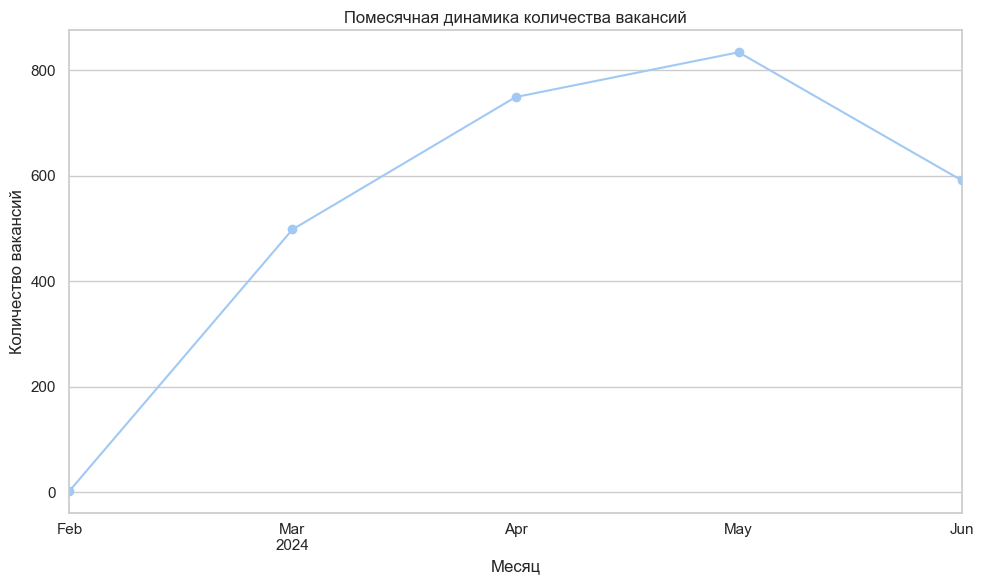

In [46]:
# Добавление столбца с месяцем
df['month'] = df['published_at'].dt.to_period('M')

# Группировка данных по месяцам и подсчет количества вакансий
monthly_counts = df.groupby('month').size()

# Создание графика
fig, ax = plt.subplots(figsize=(10, 6))
monthly_counts.plot(kind='line', marker='o', ax=ax)

# Настройка графика
ax.set_title('Помесячная динамика количества вакансий')
ax.set_xlabel('Месяц')
ax.set_ylabel('Количество вакансий')
ax.grid(True)

# Отображение графика
plt.tight_layout()
plt.show()

Пик количества вакансий пришелся на май, возможно был расчет на то что на майских праздниках люди будут свободнее и больше времени смогут уделить поиску работы.

Теперь посмотрим вакансии аналитиков и дата саентистов отдельно

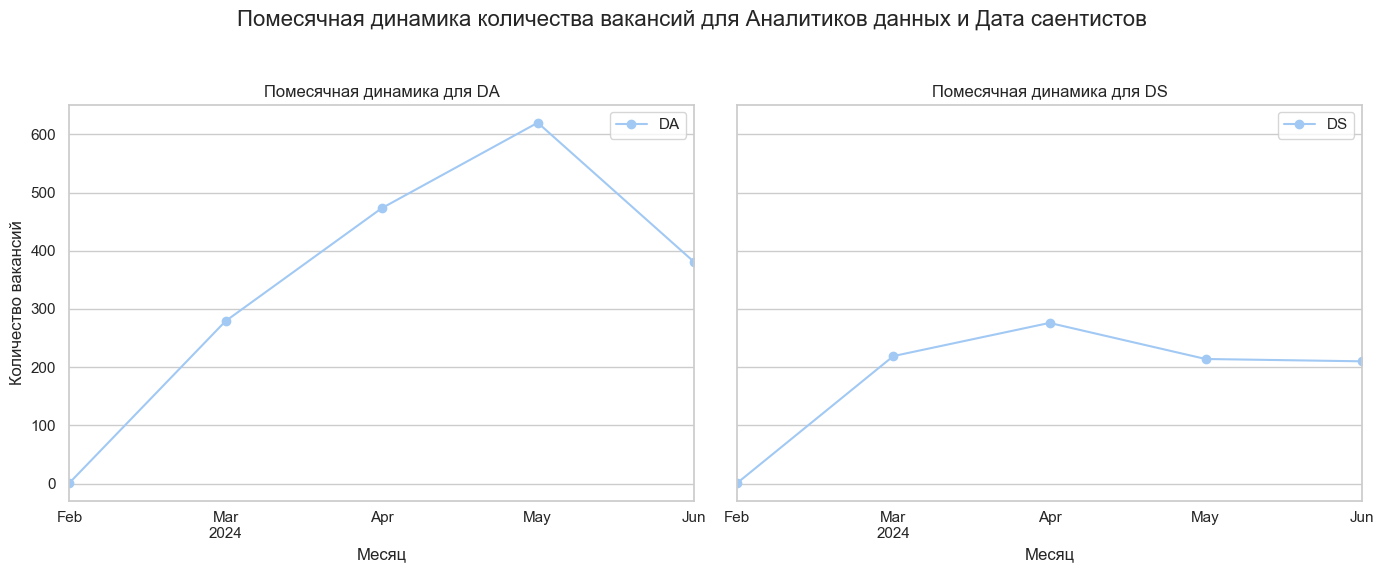

In [47]:
def plot_monthly_dynamics(df, role, ax):
    df_filtered = df[df['source'] == role]
    monthly_counts = df_filtered.groupby('month').size()
    monthly_counts.plot(ax=ax, kind='line', marker='o', label=role.upper())
    ax.set_title(f'Помесячная динамика для {role.upper()}')
    ax.set_xlabel('Месяц')
    ax.set_ylabel('Количество вакансий')
    ax.legend()

# Создание графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

roles = ['da', 'ds']

for j, role in enumerate(roles):
    plot_monthly_dynamics(df, role, axes[j])

# Добавление общего заголовка
fig.suptitle('Помесячная динамика количества вакансий для Аналитиков данных и Дата саентистов', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Установка отступов для заголовка
plt.show()

Майский пик, как оказалось вызван вакансиями аналитиков, дата саентистов больше искали в апреле.

А теперь посмотрим эту разбивку по грейдам.

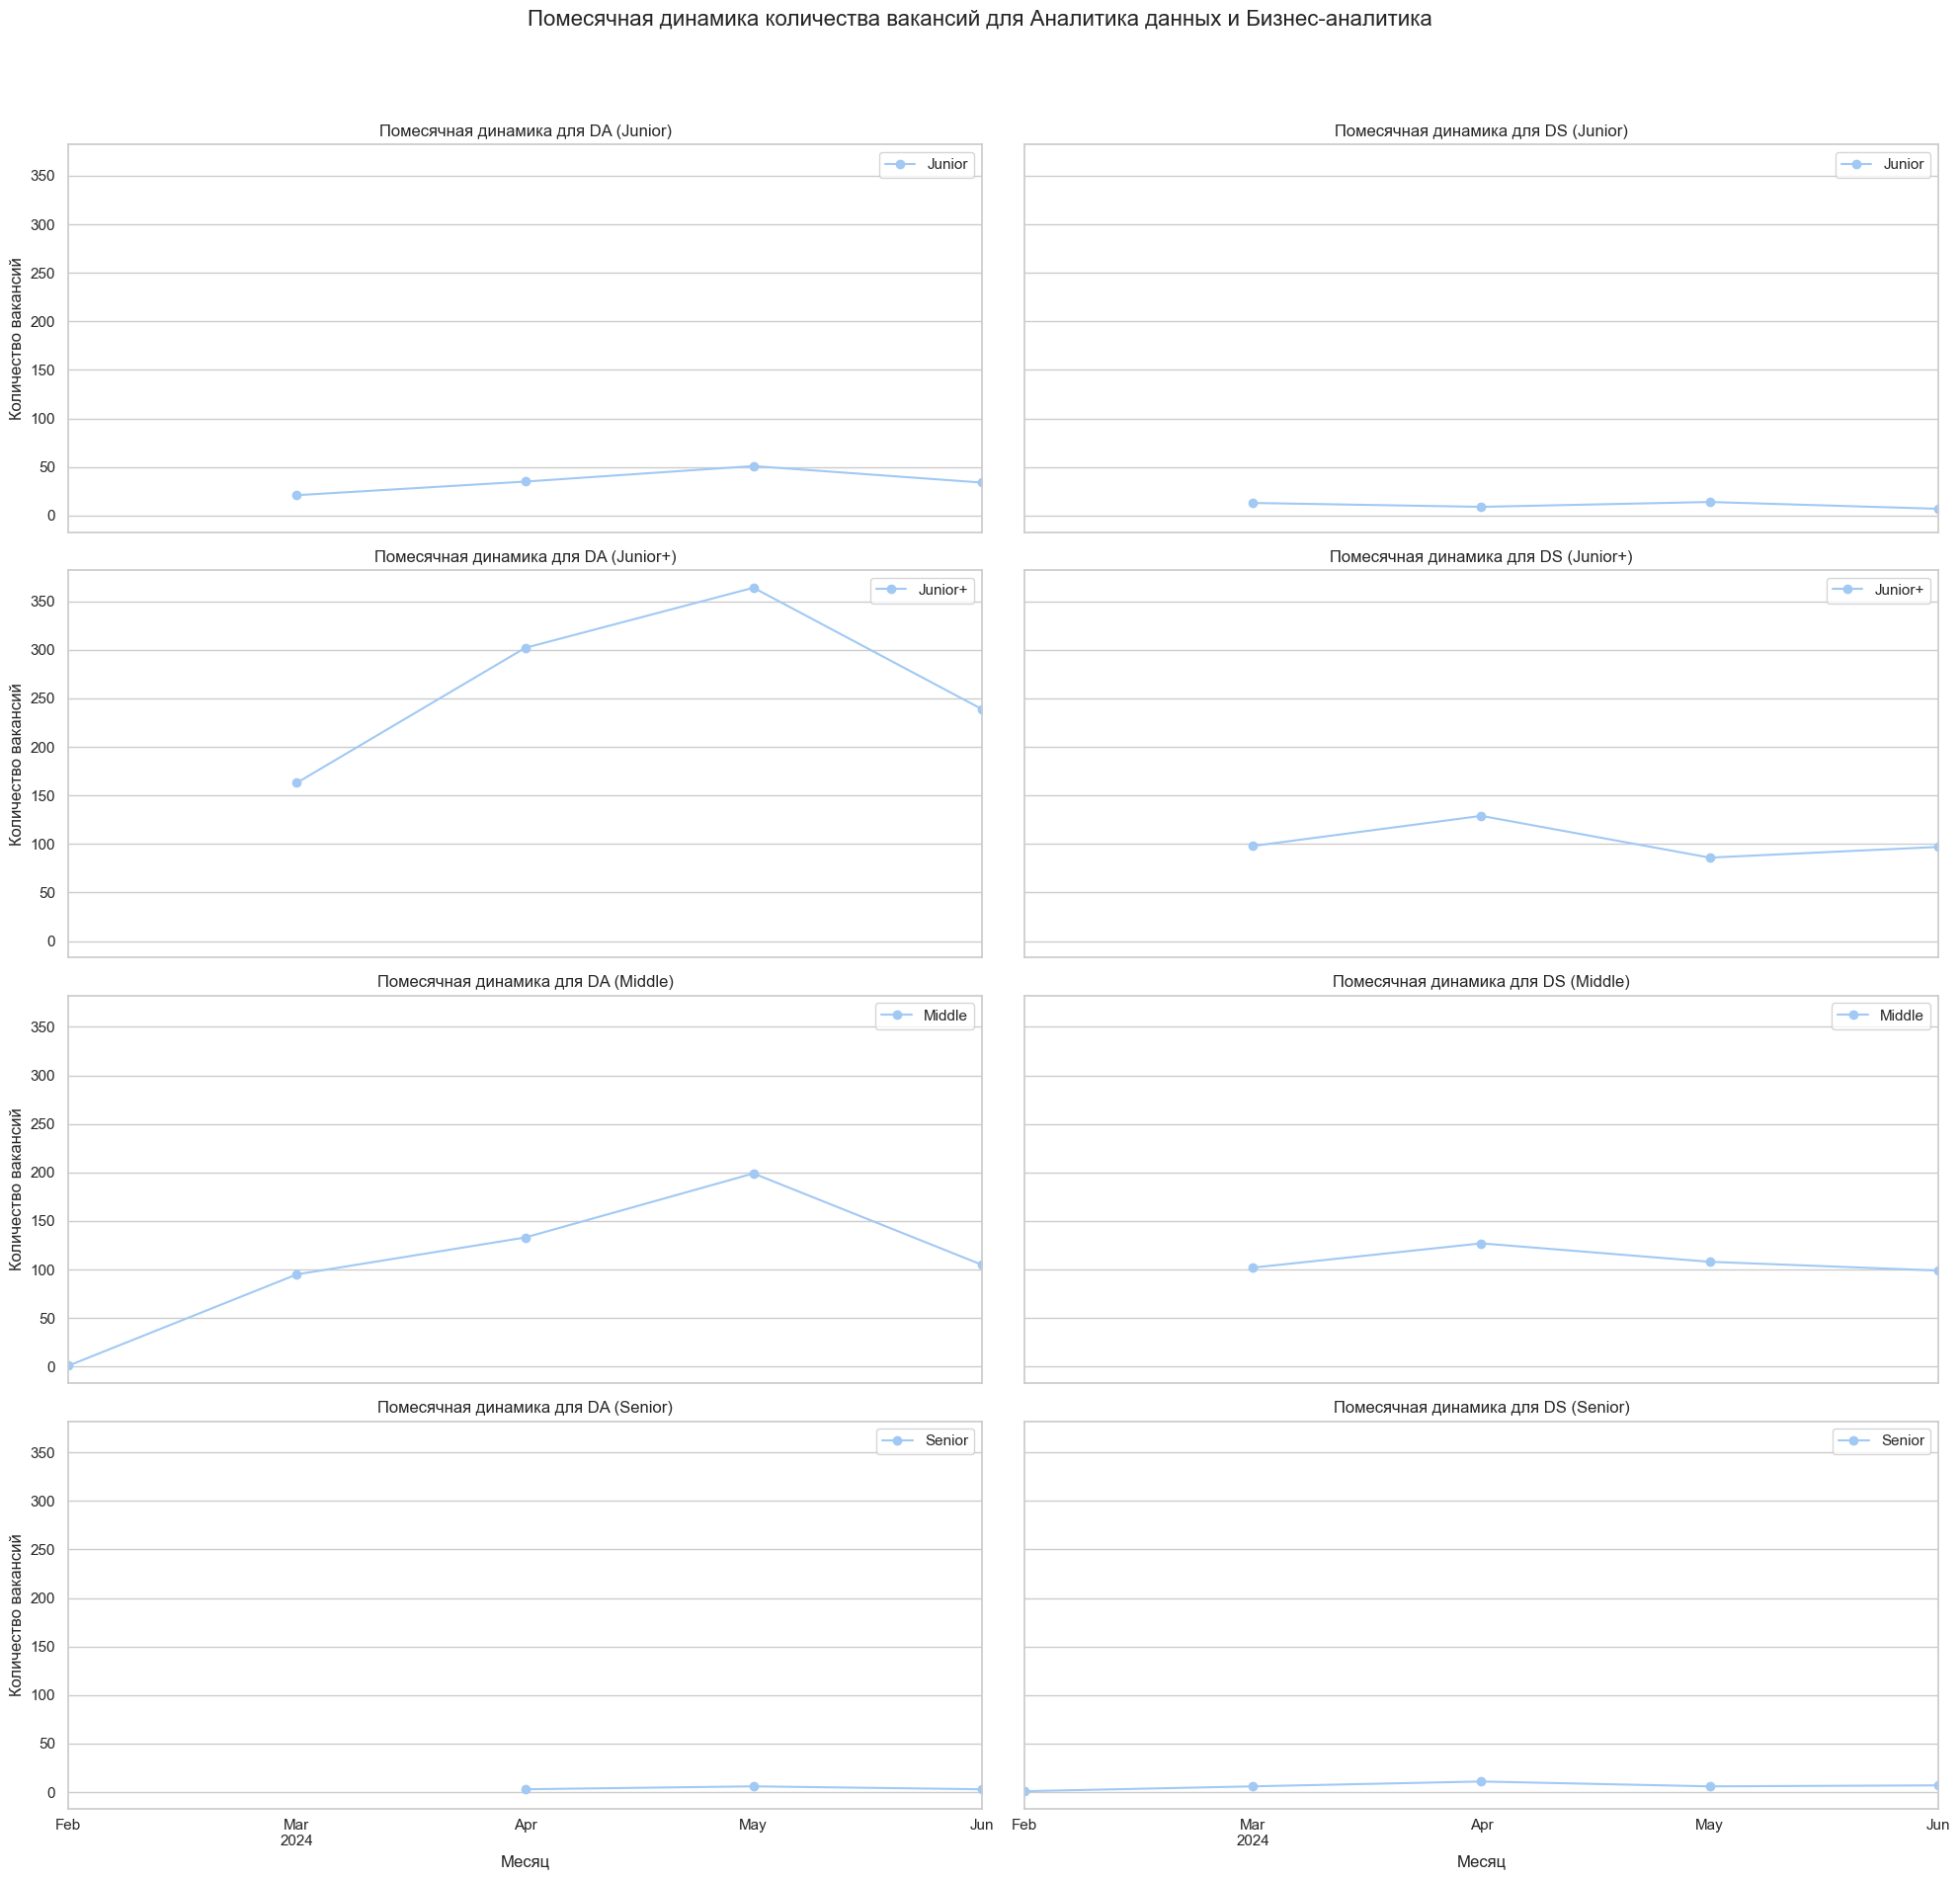

In [48]:
def plot_monthly_dynamics(df, role, grade, ax):
    df_filtered = df[(df['source'] == role) & (df['experience'] == grade)]
    monthly_counts = df_filtered.groupby('month').size()
    monthly_counts.plot(ax=ax, kind='line', marker='o', label=grade)
    ax.set_title(f'Помесячная динамика для {role.upper()} ({grade})')
    ax.set_xlabel('Месяц')
    ax.set_ylabel('Количество вакансий')
    ax.legend()

# Создание графиков
fig, axes = plt.subplots(4, 2, figsize=(20, 20), sharex=True, sharey=True)

roles = ['da', 'ds']
grades = ['Junior', 'Junior+', 'Middle', 'Senior']

for i, grade in enumerate(grades):
    for j, role in enumerate(roles):
        plot_monthly_dynamics(df, role, grade, axes[i, j])

# Добавление общего заголовка
fig.suptitle('Помесячная динамика количества вакансий для Аналитика данных и Бизнес-аналитика', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Установка отступов для заголовка
plt.show()

Майские и апрельские пики сохраняются относительно равномерно для всех грейдов.

<div style="border:solid green 2px; padding: 20px">
    
<b>✍Вывод: </b> 

Увеличение количества вакансий весной 2024 года быть связано с несколькими факторами:

1. Сезонные колебания:

Весенний период часто характеризуется активизацией рынка труда, когда компании начинают новые проекты или расширяют существующие, что приводит к увеличению спроса на специалистов.

2. Экономические условия:

Могло произойти улучшение экономической ситуации в стране, стимулирующее бизнес к расширению и найму новых сотрудников.

3. Технологические инициативы и проекты:

Вполне возможно, что были запущены крупные технологические инициативы или проекты на государственном уровне или в крупных компаниях, требующие привлечения специалистов по анализу данных и машинному обучению.

4. Образовательные программы:

Выпуск новых программ обучения и курсов в области данных и ИТ мог привести к появлению на рынке большего количества квалифицированных специалистов, что также могло стимулировать рост числа вакансий.


5. Возможные изменения в законодательстве или государственные программы поддержки ИТ-отрасли могли также способствовать росту числа вакансий.
</div>

## Формулирование выводов и рекомендаций.

<div style="border:solid blue 2px; padding: 20px">
 
<div class="alert alert-info"> <b>✍Выводы:</b> </div>
    
Была поставлена задача исследовать базу вакансий на hh.ru для Аналитиков данных и Дата сайентистов за период с 13 февраля по 11 июня 2024 года. Нужно было выявить различия в предлагаемых вакансиях.

Сделали <b>преобработку данных</b>, где объединили две выборки в одну, чтобы было удобнее с ней работать, проверили данные на дубликаты и пропусти, изменили тип данных там, где это необходимо.

Провели <b>исследовательский анализ</b>, из которого можем сделать выводы:

* 2/3 вакансий представлено для аналитиков данных;
* среди аналитиков больше всего вакансий для позиции Junior+ с опытом от 1 до 3 лет (61%), следующая по популярности вакансия на позицию Middle (30%)
* без опыта работы 8% вакансий для аналитиков (141) и всего 4,5% вакансий для датасаентистов (43)
* среди датасаентистов количество вакансий на позицию Middle и Junior+ почти одинаковое, 47,5% и 44,5% соответственно
* заработная плата практически не указывается в вакансиях
* больше всего вакансий размещено в Москве, есть вакансии в Санкт-Петербурге, в остальных городах вакансий очень мало
* компания-лидер по количеству вакансий СБЕР

При определении <b>типичного места работы</b> по грейдам среди аналитиков и датасаентистов увидели следующую картину:

* как для аналитиков так и для датасаентистов в ТОП работадателей вошли такие компании как СБЕР, Банк ВТБ, Газпромбанк, WILDBERRIES, OZON,  Ростелеком, Магнит.
* средняя зарплата у аналитиков ниже, чем у датасаентистов
* стажировка представленна в 11% вакансий аналитиков без опыта и 40% датасаентистов без опыта, в основном все остальные грейды с полной занятостью
* аналитикам проще найти вакансии с удаленной работой, чем датасаентистам


При <b>анализе навыков</b> выявили, что:

* твердые навыки, предсказуемо, спрашивают чаще, чем мягкие
* больше всего требований позиции June+
* среди аналитиков больше твердых навыков спрашивают так же у June+
* с вот среди датасаентистов твердых навыков спрашивают больше у позиции Middle

При определении <b>наиболее желаемых кандидатов</b> было выявлено:

* если говорить о soft-skills, то везде требуется знание английского
* важным софт скилом для аналитика является умение подготовки презентаций
* конмандная работа ценится в обеих сферах
* самые важные hard-skills для аналитика это SQL, Python, MS Excel и Power BI
* самые важные hard-skills для дата саентиста это Python, SQL, ML

Рассмотрение помесячной динамики количества вакансий показало, что:

* пик количества вакансий для аналитиков пришелся на май
* пик количества вакансий для датасаентистов был в апреле
* картина сохранялась и в разрезе по грейдам

Возможно это связано с сезонными колебаниями, экономическими условиями, новыми глобальными инициативами и проектами, так же возможно, что больше вакансий было размещено с надеждой, что на майских праздниках соискатели будут иметь больше возможностей с ними ознакомится.

</div>


<div style="border:solid green 2px; padding: 30px">
    
<div class="alert alert-block alert-success"><b>📝 Рекомендации</b> </div>
    
Если работодатель заинтересован привлечь внимание соискателей к вакансии и быстрее найти подходящего сотрудника можно сделать следующее:

* <b>указывать зарплату</b> - кандидат еще до отклика будет понимать подходят ему условия или нет
* <b>рассмотреть возможность удаленной работы или гибкого графика</b> - удаленная работа является предпочтительной для многих кандидатов, так как позволяет создать максимально комфортные условия для работы, если производственные процессы не позволяют сделать работу полностью удаленной можно рассмотреть вариант периодического посещения офиса по необходимости
* <b>дать шанс кандидатам без опыта</b> - звучит рискованно, но современные возможности обучения и доступность информации позволяют кандидатам готовится к будущей работе на довольно высоком уровне
</div>

## Ссылка на презентацию

### Cсылка на презентацию:

[Ссылка на презентацию](https://docs.google.com/presentation/d/1Ks-eW2B5KOErxSuNu9ir8gPC7LfCfcsh/edit?usp=sharing&ouid=100879608662216527892&rtpof=true&sd=true "Нажмите, чтобы перейти по ссылке")

### Cсылка на pdf-файл с презентацией:

[Ссылка на PDF файл с презентацией](https://drive.google.com/file/d/1dj3pha9ZnwA9PqH0YREZLVAqo8FAVlw8/view?usp=sharing "Нажмите, чтобы перейти по ссылке")